In [1]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (Matplotlib에서 한글 깨짐 방지)
import matplotlib.pyplot as plt

plt.rc("font", family="NanumGothic")  # Windows 사용자의 경우

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

# 기본 라이브러리
import polars as pl
import pandas as pd
import seaborn as sns

# 시각화용 색상 팔레트
color_palette = sns.color_palette("mako", as_cmap=False)

In [2]:
df = pl.read_csv('data/CUSTOMER_SCORE_금리.csv')

In [3]:
def aggregate_customer_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    고객 단위로 주요 금융 항목을 집계하여 요약 데이터를 생성합니다.

    처리 내용:
    1. '기준금리', '성별' 컬럼 제거
    2. 고객ID 기준 그룹화 후 다음과 같이 집계:
        - 입출금예금, 기타예금, 비이자상품, 카드, 대출, 총점수: 평균값
        - 거래기간(개월), 연령대: 최대값
        - 보유상품수:
            - 최대_보유상품종류: 최대값
            - 평균_보유상품종류: 평균값을 반올림 후 Int8 형으로 변환

    Parameters:
        df (pl.DataFrame): 원본 고객 월별 데이터

    Returns:
        pl.DataFrame: 고객ID 기준으로 집계된 요약 데이터프레임
    """
    df_dropped = df.drop(["기준금리", "성별"])

    df_agg = (
        df_dropped
        .group_by("고객ID")
        .agg([
            pl.col("입출금예금").mean().alias("평균_입출금예금"),
            pl.col("기타예금").mean().alias("평균_기타예금"),
            pl.col("비이자상품").mean().alias("평균_비이자상품"),
            pl.col("카드").mean().alias("평균_카드"),
            pl.col("대출").mean().alias("평균_대출"),
            pl.col("총점수").mean().alias("평균_총점수"),
            pl.col("거래기간(개월)").max().alias("거래기간(개월)"),
            pl.col("연령대").max().alias("연령대"),
            pl.col("보유상품수").max().alias("최대_보유상품종류"),
            pl.col("보유상품수").mean().round(0).cast(pl.Int8).alias("평균_보유상품종류")
        ])
    )
    return df_agg

In [4]:
temp = df.clone()
customer_agg = aggregate_customer_data(temp)

In [5]:
customer_agg.head()

고객ID,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출,평균_총점수,거래기간(개월),연령대,최대_보유상품종류,평균_보유상품종류
i64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i8
2772302056,169565.217391,0.0,0.0,0.0,1.9504e7,7725.911594,23,30,2,2
7084529048,1.8806e6,0.0,1.3503e7,7096.774194,0.0,1028.068817,36,40,3,2
7592653016,267741.935484,0.0,0.0,0.0,0.0,45.72043,36,60,1,1
7225330529,2.0387e6,0.0,0.0,0.0,790322.580645,505.637634,36,60,2,1
2383687052,0.0,0.0,0.0,0.0,4.28e6,1057.466667,10,60,1,1


In [145]:
#customer_agg.write_csv('./dataset/customer_agg.csv')

In [5]:
clustering_origin = customer_agg[['고객ID', '연령대', '평균_총점수']].clone()

In [6]:
clustering_origin

고객ID,연령대,평균_총점수
i64,i64,f64
6975835756,40,116.410753
7085386831,40,32.376344
5157791060,30,1224.021505
7626815327,30,202.52043
4974400940,30,3001.506048
…,…,…
2846727906,30,628.046726
5388844559,60,307.076478
4382915892,20,11.548387


# 분류하기

## 1. 분위수 기반 분류 (3단계)

In [7]:
# 분위수 기준값 구하기
q1 = clustering_origin.select(pl.col("평균_총점수").quantile(0.33)).item()
q2 = clustering_origin.select(pl.col("평균_총점수").quantile(0.66)).item()

In [8]:
print(q1,q2)

87.44086021505377 465.3016666666666


In [9]:
clustering_origin.describe()

statistic,고객ID,연령대,평균_총점수
str,f64,f64,f64
"""count""",1.978693e6,1.978693e6,1.978693e6
"""null_count""",0.0,0.0,0.0
"""mean""",5.9962e9,41.132475,1353.17282
"""std""",2.3083e9,15.895499,3893.98679
"""min""",2.0004e9,10.0,0.0
"""25%""",4.0012e9,30.0,54.322581
"""50%""",5.9888e9,40.0,213.073118
"""75%""",7.9953e9,60.0,773.23871
"""max""",1.0000e10,60.0,48186.003846


In [13]:
tmp_test = customer_agg.drop(["고객ID", '연령대'])

tmp_test.describe()

statistic,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출,평균_총점수,거래기간(개월),최대_보유상품종류,평균_보유상품종류
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.978693e6,1.978693e6,1.978693e6,1.978693e6,1.978693e6,1.978693e6,1.978693e6,1.978693e6,1.978693e6
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",3.0709e6,2.6716e6,156457.756266,141267.836559,2.5459e6,1353.17282,28.502966,1.861411,1.351349
"""std""",6.9741e6,9.1386e6,2.1488e6,374575.86566,9.9298e6,3893.98679,6.95043,0.879224,0.910711
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"""25%""",68750.0,0.0,0.0,0.0,0.0,54.322581,31.0,1.0,1.0
"""50%""",535483.870968,0.0,0.0,0.0,0.0,213.073118,31.0,2.0,1.0
"""75%""",2.8290e6,441935.483871,0.0,98709.677419,0.0,773.23871,31.0,2.0,2.0
"""max""",1.855e8,1.84e8,9.9e7,3.29e7,9.9e7,48186.003846,31.0,5.0,5.0


In [14]:
# 등급부여
clustering_origin = clustering_origin.with_columns(
    pl.when(pl.col("평균_총점수") < q1).then(pl.lit("하"))
    .when(pl.col("평균_총점수") < q2).then(pl.lit("중"))
    .otherwise(pl.lit("상"))
    .alias("분위수_충성도등급")
)

In [15]:
clustering_origin

고객ID,연령대,평균_총점수,분위수_충성도등급
i64,i64,f64,str
6975835756,40,116.410753,"""중"""
7085386831,40,32.376344,"""하"""
5157791060,30,1224.021505,"""상"""
7626815327,30,202.52043,"""중"""
4974400940,30,3001.506048,"""상"""
…,…,…,…
2846727906,30,628.046726,"""상"""
5388844559,60,307.076478,"""중"""
4382915892,20,11.548387,"""하"""


## 2. 비지도학습 기반 분류 (평균 총 점수, best k 찾기)

In [17]:
# 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
import pandas as pd

In [18]:
# 데이터 준비
df = clustering_origin.clone()
# Polars에서 수치형 컬럼만 추출
numeric_columns = [col for col, dtype in df.schema.items() if dtype in pl.NUMERIC_DTYPES]
exclude_cols = ["고객ID", "연령대"]  # 분석에서 제외할 컬럼
use_columns = [col for col in numeric_columns if col not in exclude_cols]

X = df.select(use_columns)
X_scaled = StandardScaler().fit_transform(X.to_numpy())

In [29]:
tmp_scaled = StandardScaler().fit_transform(tmp_test)

### k means

In [36]:
results = []

# k값을 2부터 9까지 반복하며 클러스터 평가
for k in range(2, 10):
    # KMeans 클러스터링 모델 학습
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    # silhouette score 계산 시 너무 느려지는 걸 방지하기 위해 1만 개만 샘플링
    X_sampled, labels_sampled = resample(
        X_scaled, labels,
        n_samples=min(10000, len(X_scaled)),
        random_state=42
    )

    # 세 가지 평가 지표 계산
    results.append({
        "k": k,
        "silhouette": silhouette_score(X_sampled, labels_sampled),          # 군집 간 분리 + 내부 응집
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),     # 분산 기반 평가
        "davies_bouldin": davies_bouldin_score(X_scaled, labels)            # 군집 간 거리 / 내부 거리 (낮을수록 좋음)
    })

# 리스트 → DataFrame 변환
result_df_kmeans = pd.DataFrame(results)

# 각 지표에 대해 순위 계산
# silhouette / ch는 클수록 좋으므로 내림차순(ascending=False)
# db는 작을수록 좋으므로 오름차순(ascending=True)
result_df_kmeans["rank_silhouette"] = result_df_kmeans["silhouette"].rank(ascending=False)
result_df_kmeans["rank_ch"] = result_df_kmeans["calinski_harabasz"].rank(ascending=False)
result_df_kmeans["rank_db"] = result_df_kmeans["davies_bouldin"].rank(ascending=True)

# 평균 순위 계산 → 종합 평가 지표로 활용
result_df_kmeans["rank_avg"] = result_df_kmeans[["rank_silhouette", "rank_ch", "rank_db"]].mean(axis=1)

# 평균 순위가 가장 낮은(즉, 전체적으로 가장 높은 평가를 받은) k를 Best k로 선정
best_k_rank = result_df_kmeans.loc[result_df_kmeans["rank_avg"].idxmin(), "k"]

In [52]:
results = []

# k값을 2부터 9까지 반복하며 클러스터 평가
for k in range(2, 10):
    # KMeans 클러스터링 모델 학습
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(tmp_test)

    # silhouette score 계산 시 너무 느려지는 걸 방지하기 위해 1만 개만 샘플링
    X_sampled, labels_sampled = resample(
        tmp_test, labels,
        n_samples=min(10000, len(tmp_test)),
        random_state=42
    )

    # 세 가지 평가 지표 계산
    results.append({
        "k": k,
        "silhouette": silhouette_score(X_sampled, labels_sampled),          # 군집 간 분리 + 내부 응집
        "calinski_harabasz": calinski_harabasz_score(tmp_test, labels),     # 분산 기반 평가
        "davies_bouldin": davies_bouldin_score(tmp_test, labels)            # 군집 간 거리 / 내부 거리 (낮을수록 좋음)
    })

# 리스트 → DataFrame 변환
result_df_kmeans = pd.DataFrame(results)

# 각 지표에 대해 순위 계산
# silhouette / ch는 클수록 좋으므로 내림차순(ascending=False)
# db는 작을수록 좋으므로 오름차순(ascending=True)
result_df_kmeans["rank_silhouette"] = result_df_kmeans["silhouette"].rank(ascending=False)
result_df_kmeans["rank_ch"] = result_df_kmeans["calinski_harabasz"].rank(ascending=False)
result_df_kmeans["rank_db"] = result_df_kmeans["davies_bouldin"].rank(ascending=True)

# 평균 순위 계산 → 종합 평가 지표로 활용
result_df_kmeans["rank_avg"] = result_df_kmeans[["rank_silhouette", "rank_ch", "rank_db"]].mean(axis=1)

# 평균 순위가 가장 낮은(즉, 전체적으로 가장 높은 평가를 받은) k를 Best k로 선정
best_k_rank = result_df_kmeans.loc[result_df_kmeans["rank_avg"].idxmin(), "k"]

In [41]:
result_df_kmeans

,k,silhouette,calinski_harabasz,davies_bouldin,rank_silhouette,rank_ch,rank_db,rank_avg
0,2,0.800512,9.517799e+05,0.516592,2.0,8.0,1.0,3.666667
1,3,0.802055,1.429116e+06,0.602804,1.0,5.0,2.0,2.666667
2,4,0.758862,1.521349e+06,0.678609,3.0,2.0,4.0,3.000000
3,5,0.738016,1.471668e+06,0.677981,4.0,3.0,3.0,3.333333
4,6,0.700838,1.306040e+06,0.710365,6.0,7.0,5.0,6.000000
5,7,0.713409,1.433737e+06,0.714757,5.0,4.0,6.0,5.000000
6,8,0.698985,1.395839e+06,0.763790,7.0,6.0,8.0,7.000000
7,9,0.698188,1.531039e+06,0.744870,8.0,1.0,7.0,5.333333


In [42]:
best_k_rank

3

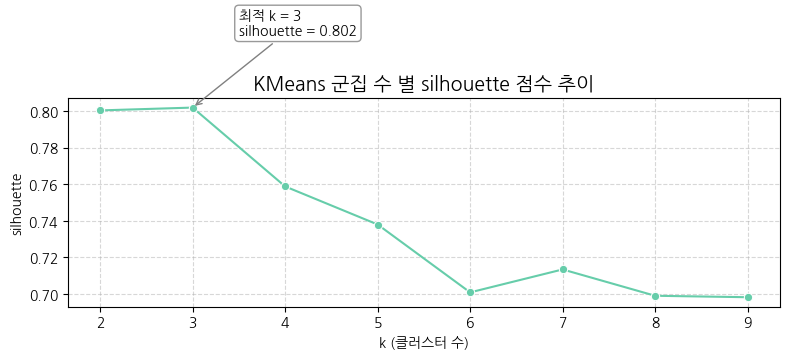

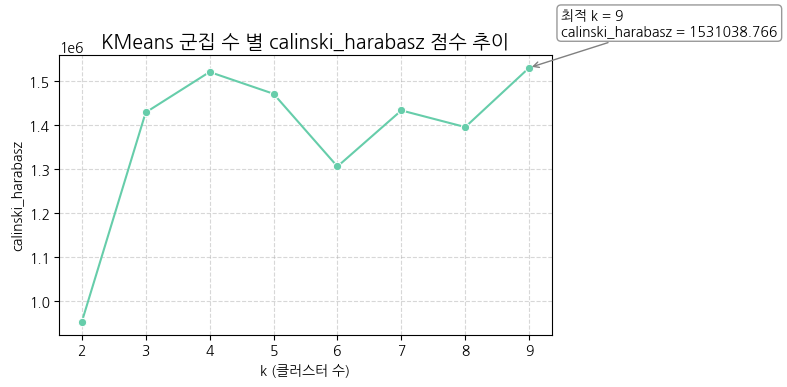

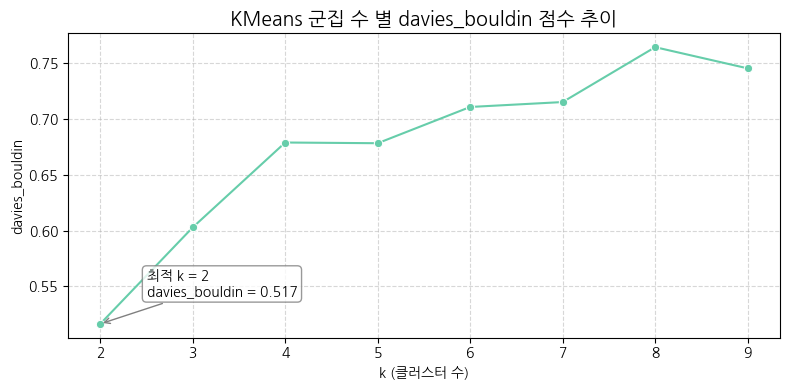

In [43]:
# kmeans seaborn 시각화
# KMeans 클러스터링 평가 결과 데이터프레임 복사 (원본 데이터 유지)
result_df = result_df_kmeans.copy()

# 클러스터 평가 지표 정의
metrics = {
    "silhouette": "max",          # Silhouette Score: 클수록 좋음 (0~1)
    "calinski_harabasz": "max",   # Calinski-Harabasz Score: 클수록 좋음
    "davies_bouldin": "min",      # Davies-Bouldin Score: 작을수록 좋음
}

# 정의된 평가 지표에 대해 반복 실행
for metric, direction in metrics.items():
    plt.figure(figsize=(8, 4))  # 그래프 크기 설정

    # K별 metric 점수 그래프 그리기
    sns.lineplot(data=result_df, x="k", y=metric, marker="o", color="mediumaquamarine")

    # 최적 k값 찾기 (각 지표의 최고 또는 최저값)
    if direction == "max":
        best_idx = result_df[metric].idxmax()  # 가장 큰 값의 인덱스 찾기
    else:
        best_idx = result_df[metric].idxmin()  # 가장 작은 값의 인덱스 찾기

    best_k = result_df.loc[best_idx, "k"]  # 최적 k값
    best_score = result_df.loc[best_idx, metric]  # 최적 metric 점수

    # 최적 k값에 주석(Annotate) 추가
    plt.annotate(
        f"최적 k = {best_k}\n{metric} = {best_score:.3f}",  # 텍스트 내용
        xy=(best_k, best_score),  # 화살표 위치 (x, y)
        xytext=(best_k + 0.5, best_score + 0.05 * best_score),  # 텍스트 위치 (조금 위쪽)
        arrowprops=dict(arrowstyle="->", color="gray"),  # 화살표 스타일
        fontsize=10,  # 폰트 크기
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)  # 텍스트 배경 스타일
    )

    # 그래프 제목 및 라벨 설정
    plt.title(f"KMeans 군집 수 별 {metric} 점수 추이", fontsize=14)
    plt.xlabel("k (클러스터 수)")
    plt.ylabel(metric)
    plt.grid(True, linestyle='--', alpha=0.5)  # 점선 형태의 그리드 추가
    plt.tight_layout()  # 레이아웃 최적화
    plt.show()  # 그래프 출력

In [44]:
# kmeans plotly 시각화

# 결과 복사
result_df = result_df_kmeans.copy()

# 라이브러리 load
import plotly.graph_objects as go

# 빈 Figure 생성
fig = go.Figure()

# 지표 정의 (어느 축에 그릴지, 최적값 기준, 색상 지정)
metrics = {
    "silhouette": {"axis": "y", "mode": "max", "color": "mediumaquamarine"}, # silhouette: y축, 클수록 좋음
    "calinski_harabasz": {"axis": "y", "mode": "max", "color": "seagreen"},  # ch: y축, 클수록 좋음
    "davies_bouldin": {"axis": "y2", "mode": "min", "color": "mediumseagreen"} # db: y2축, 작을수록 좋음
}

# 각 지표에 대해 반복 처리
for metric, props in metrics.items():
    yaxis = props["axis"]
    mode = props["mode"]
    color = props["color"]

    # ① 지표별 선 그래프 추가
    fig.add_trace(go.Scatter(
        x=result_df["k"],
        y=result_df[metric],
        mode="lines+markers",
        name=metric,
        yaxis=yaxis,
        line=dict(color=color)
    ))

    # ② 해당 지표에서 최적 k값 (최댓값 or 최솟값)
    best_row = result_df.sort_values(metric, ascending=(mode == "min")).iloc[0]
    best_k = best_row["k"]
    best_score = best_row[metric]

    # ③ 최적 k 지점 강조 (점 + 텍스트 표시)
    fig.add_trace(go.Scatter(
        x=[best_k],
        y=[best_score],
        mode="markers+text",
        name=f"{metric} 최적 k={best_k}",
        yaxis=yaxis,
        marker=dict(size=12, color=color, symbol='circle'),
        text=[f"{best_score:.3f}"],
        textposition="top center",
        showlegend=False
    ))

# 전체 그래프 레이아웃 설정
fig.update_layout(
    title="KMeans 클러스터 평가 지표",
    xaxis=dict(title="k (클러스터 수)"),
    yaxis=dict(title="Silhouette / Calinski-Harabasz"),
    yaxis2=dict(title="Davies-Bouldin (↓)", overlaying="y", side="right"),
    legend=dict(x=0.01, y=0.99),
    height=500
)

fig.show()


### gmm

- 풀 데이터 기준 21분 걸린다다

In [46]:
results = []

# k값을 2부터 9까지 반복하며 GMM 클러스터 평가
for k in range(2, 10):
    # GMM 클러스터링 모델 학습
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(tmp_test)

    # silhouette score 계산 시 너무 느려지는 걸 방지하기 위해 1만 개만 샘플링
    X_sampled, labels_sampled = resample(
        X_scaled, labels,
        n_samples=min(10000, len(X_scaled)),
        random_state=42
    )

    # 세 가지 평가 지표 계산
    results.append({
        "k": k,
        "silhouette": silhouette_score(X_sampled, labels_sampled),          # 군집 간 분리 + 내부 응집
        "calinski_harabasz": calinski_harabasz_score(tmp_test, labels),     # 분산 기반 평가
        "davies_bouldin": davies_bouldin_score(tmp_test, labels)            # 군집 간 거리 / 내부 거리 (낮을수록 좋음)
    })

# 리스트 → DataFrame 변환
result_df_gmm = pd.DataFrame(results)

# 각 지표에 대해 순위 계산
# silhouette / ch는 클수록 좋으므로 내림차순(ascending=False)
# db는 작을수록 좋으므로 오름차순(ascending=True)
result_df_gmm["rank_silhouette"] = result_df_gmm["silhouette"].rank(ascending=False)
result_df_gmm["rank_ch"] = result_df_gmm["calinski_harabasz"].rank(ascending=False)
result_df_gmm["rank_db"] = result_df_gmm["davies_bouldin"].rank(ascending=True)

# 평균 순위 계산 → 종합 평가 지표로 활용
result_df_gmm["rank_avg"] = result_df_gmm[["rank_silhouette", "rank_ch", "rank_db"]].mean(axis=1)

# 평균 순위가 가장 낮은(즉, 전체적으로 가장 높은 평가를 받은) k를 Best k로 선정
best_k_rank_gmm = result_df_gmm.loc[result_df_gmm["rank_avg"].idxmin(), "k"]

In [47]:
result_df_gmm

,k,silhouette,calinski_harabasz,davies_bouldin,rank_silhouette,rank_ch,rank_db,rank_avg
0,2,0.721746,330234.780008,1.697930,1.0,1.0,1.0,1.000000
1,3,0.440550,150355.639497,2.048745,2.0,3.0,2.0,2.333333
2,4,-0.049535,118966.301117,2.730934,7.0,6.0,3.0,5.333333
3,5,0.308774,156035.455514,2.995120,3.0,2.0,4.0,3.000000
4,6,0.274207,141437.361436,3.189251,4.0,4.0,5.0,4.333333
5,7,-0.016145,70300.475438,3.203800,5.0,8.0,6.0,6.333333
6,8,-0.026745,85624.428701,3.957775,6.0,7.0,8.0,7.000000
7,9,-0.084976,133054.513054,3.223835,8.0,5.0,7.0,6.666667


In [48]:
best_k_rank_gmm

2

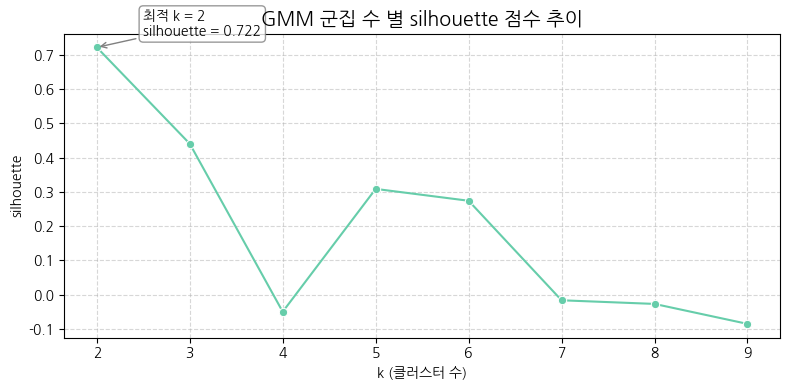

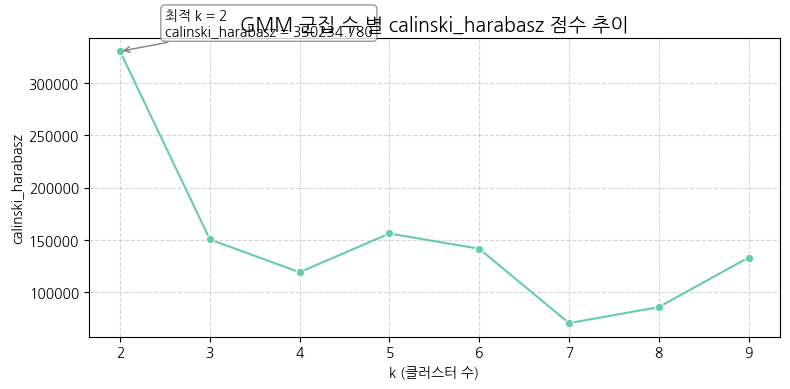

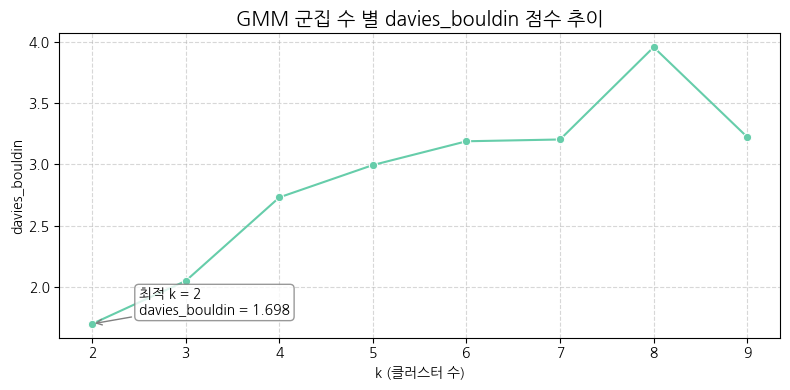

In [49]:
# gmm seaborn 시각화
# GMM 클러스터링 평가 결과 데이터프레임 복사 (원본 데이터 유지)
result_df = result_df_gmm.copy()

# 클러스터 평가 지표 정의
metrics = {
    "silhouette": "max",          # Silhouette Score: 클수록 좋음 (0~1)
    "calinski_harabasz": "max",   # Calinski-Harabasz Score: 클수록 좋음
    "davies_bouldin": "min",      # Davies-Bouldin Score: 작을수록 좋음
}

# 정의된 평가 지표에 대해 반복 실행
for metric, direction in metrics.items():
    plt.figure(figsize=(8, 4))  # 그래프 크기 설정

    # K별 metric 점수 그래프 그리기
    sns.lineplot(data=result_df, x="k", y=metric, marker="o", color="mediumaquamarine")

    # 최적 k값 찾기 (각 지표의 최고 또는 최저값)
    best_idx = result_df[metric].idxmax() if direction == "max" else result_df[metric].idxmin()
    best_k = result_df.loc[best_idx, "k"]  # 최적 k값
    best_score = result_df.loc[best_idx, metric]  # 최적 metric 점수

    # 최적 k값에 주석(Annotate) 추가
    plt.annotate(
        f"최적 k = {best_k}\n{metric} = {best_score:.3f}",
        xy=(best_k, best_score),
        xytext=(best_k + 0.5, best_score + 0.05 * best_score),
        arrowprops=dict(arrowstyle="->", color="gray"),
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )

    # 그래프 제목 및 라벨 설정
    plt.title(f"GMM 군집 수 별 {metric} 점수 추이", fontsize=14)
    plt.xlabel("k (클러스터 수)")
    plt.ylabel(metric)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [50]:
# 결과 복사 (GMM 결과 사용)
result_df = result_df_gmm.copy()

# 라이브러리
import plotly.graph_objects as go

# 빈 Figure 생성
fig = go.Figure()

# 지표 정의 (y축 배치, 최적값 방향, 색상)
metrics = {
    "silhouette": {"axis": "y", "mode": "max", "color": "mediumaquamarine"}, # 클수록 좋음
    "calinski_harabasz": {"axis": "y", "mode": "max", "color": "seagreen"},
    "davies_bouldin": {"axis": "y2", "mode": "min", "color": "mediumseagreen"} # 작을수록 좋음 → y2축
}


# 각 지표별로 선 그래프 + 최적 k 표시
for metric, props in metrics.items():
    yaxis = props["axis"]
    mode = props["mode"]
    color = props["color"]

    # ① 지표별 라인 그래프 추가
    fig.add_trace(go.Scatter(
        x=result_df["k"],
        y=result_df[metric],
        mode="lines+markers",
        name=metric,
        yaxis=yaxis,
        line=dict(color=color)
    ))

    # ② 최적 k 계산 (최댓값 or 최솟값 기준)
    best_row = result_df.sort_values(metric, ascending=(mode == "min")).iloc[0]
    best_k = best_row["k"]
    best_score = best_row[metric]

    # ③ 최적 k 지점에 점 + 텍스트 추가
    fig.add_trace(go.Scatter(
        x=[best_k],
        y=[best_score],
        mode="markers+text",
        name=f"{metric} 최적 k={best_k}",
        yaxis=yaxis,
        marker=dict(size=12, color=color, symbol='circle'),
        text=[f"{best_score:.3f}"],
        textposition="top center",
        showlegend=False
    ))

# 전체 레이아웃 설정
fig.update_layout(
    title="GMM 클러스터 평가 지표",
    xaxis=dict(title="k (클러스터 수)"),
    yaxis=dict(title="Silhouette / Calinski-Harabasz"),
    yaxis2=dict(title="Davies-Bouldin (↓)", overlaying="y", side="right"),
    legend=dict(x=0.01, y=0.99),
    height=500
)

fig.show()


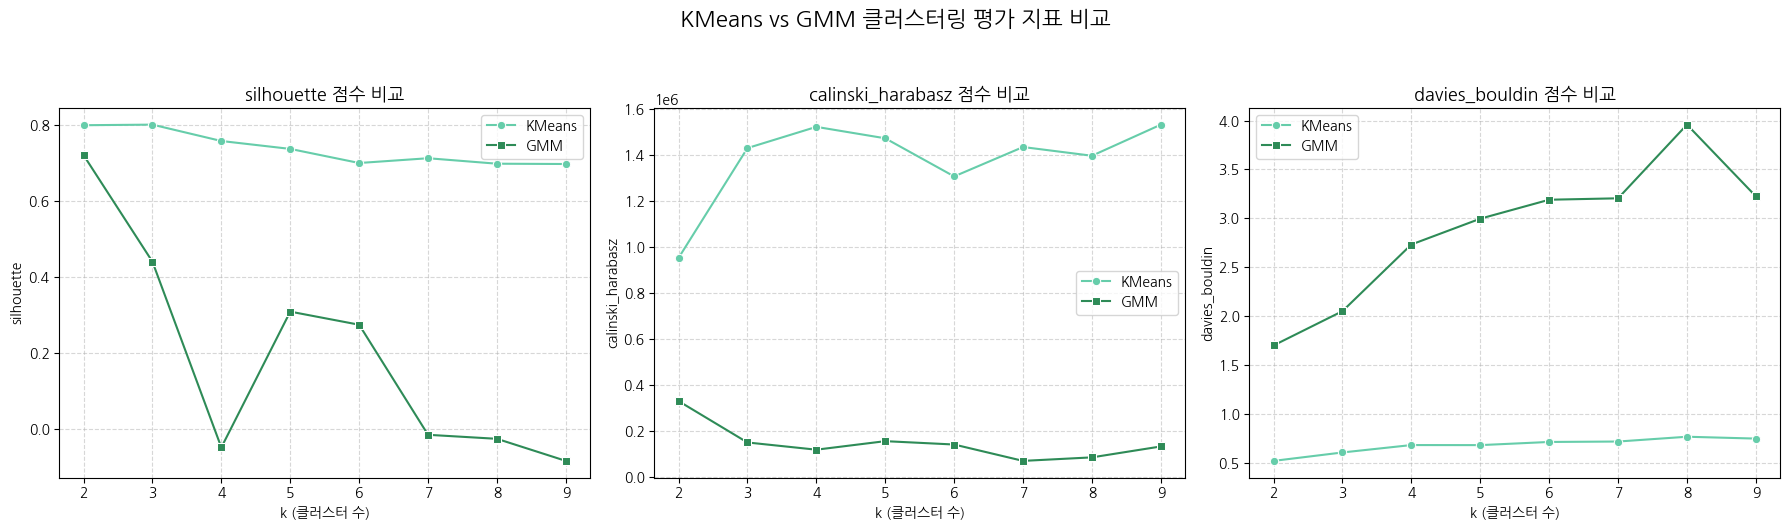

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# 비교할 지표 리스트
metrics = ["silhouette", "calinski_harabasz", "davies_bouldin"]

# 서브플롯 준비 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# 지표별로 subplot에 추가
for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # KMeans 점수 라인
    sns.lineplot(data=result_df_kmeans, x="k", y=metric, marker="o", label="KMeans", ax=ax, color="mediumaquamarine")
    
    # GMM 점수 라인
    sns.lineplot(data=result_df_gmm, x="k", y=metric, marker="s", label="GMM", ax=ax, color="seagreen")
    
    # 그래프 꾸미기
    ax.set_title(f"{metric} 점수 비교", fontsize=13)
    ax.set_xlabel("k (클러스터 수)")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

plt.suptitle("KMeans vs GMM 클러스터링 평가 지표 비교", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


### 최적 K 정하기

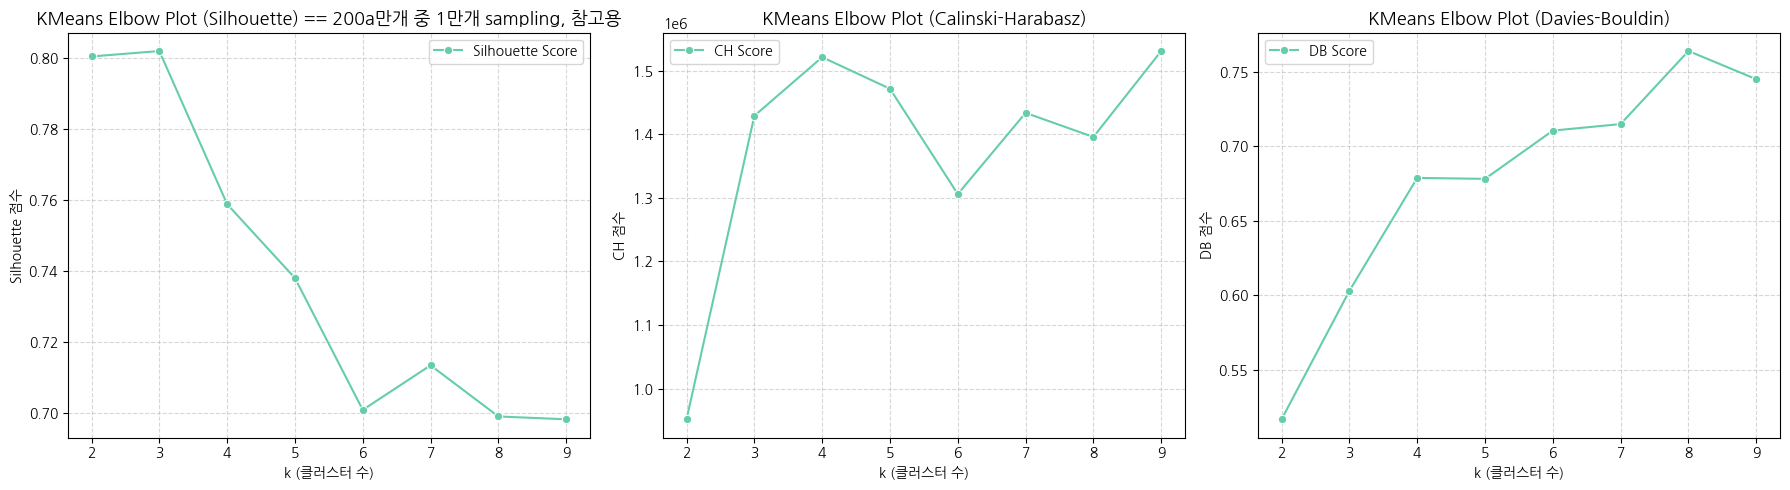

In [53]:
# 서브플롯 준비 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# 첫 번째 subplot - Silhouette
sns.lineplot(
    data=result_df_kmeans,
    x="k",
    y="silhouette",
    marker="o",
    label="Silhouette Score",
    color="mediumaquamarine",
    ax=axes[0]
)
axes[0].set_title("KMeans Elbow Plot (Silhouette) == 200a만개 중 1만개 sampling, 참고용", fontsize=13)
axes[0].set_xlabel("k (클러스터 수)")
axes[0].set_ylabel("Silhouette 점수")
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend()

# 두 번째 subplot - Calinski-Harabasz
sns.lineplot(
    data=result_df_kmeans,
    x="k",
    y="calinski_harabasz",
    marker="o",
    label="CH Score",
    color="mediumaquamarine",
    ax=axes[1]
)
axes[1].set_title("KMeans Elbow Plot (Calinski-Harabasz)", fontsize=13)
axes[1].set_xlabel("k (클러스터 수)")
axes[1].set_ylabel("CH 점수")
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend()

# 세 번째 subplot - Davies-Bouldin
sns.lineplot(
    data=result_df_kmeans,
    x="k",
    y="davies_bouldin",
    marker="o",
    label="DB Score",
    color="mediumaquamarine",
    ax=axes[2]
)
axes[2].set_title("KMeans Elbow Plot (Davies-Bouldin)", fontsize=13)
axes[2].set_xlabel("k (클러스터 수)")
axes[2].set_ylabel("DB 점수")
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].legend()

# 전체 레이아웃 정리
plt.tight_layout()
plt.show()

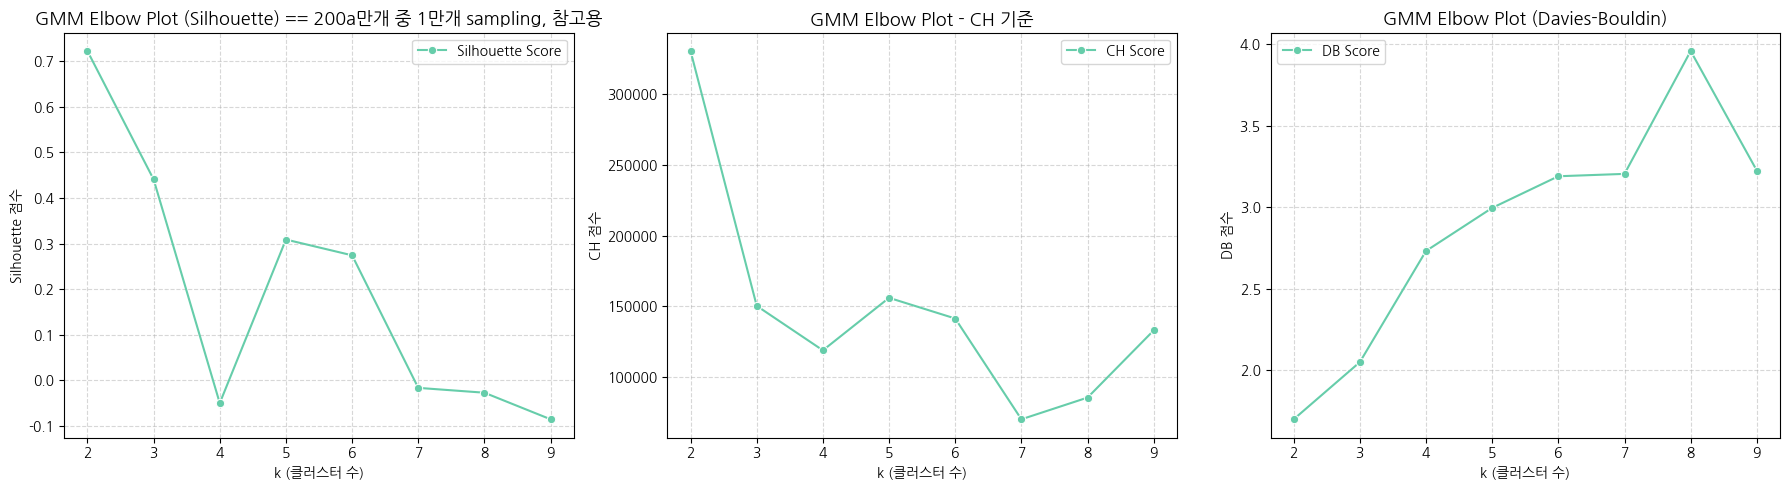

In [54]:
# 서브플롯 준비 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# 첫 번째 subplot - Silhouette
sns.lineplot(
    data=result_df_gmm,
    x="k",
    y="silhouette",
    marker="o",
    label="Silhouette Score",
    color="mediumaquamarine",
    ax=axes[0]
)
axes[0].set_title("GMM Elbow Plot (Silhouette) == 200a만개 중 1만개 sampling, 참고용", fontsize=13)
axes[0].set_xlabel("k (클러스터 수)")
axes[0].set_ylabel("Silhouette 점수")
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend()

# 두 번째 subplot - Calinski-Harabasz
sns.lineplot(
    data=result_df_gmm,
    x="k",
    y="calinski_harabasz",
    marker="o",
    label="CH Score",
    color="mediumaquamarine",
    ax=axes[1]
)
axes[1].set_title("GMM Elbow Plot - CH 기준", fontsize=13)
axes[1].set_xlabel("k (클러스터 수)")
axes[1].set_ylabel("CH 점수")
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend()

# 세 번째 subplot - Davies-Bouldin
sns.lineplot(
    data=result_df_gmm,
    x="k",
    y="davies_bouldin",
    marker="o",
    label="DB Score",
    color="mediumaquamarine",
    ax=axes[2]
)
axes[2].set_title("GMM Elbow Plot (Davies-Bouldin)", fontsize=13)
axes[2].set_xlabel("k (클러스터 수)")
axes[2].set_ylabel("DB 점수")
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].legend()

# 전체 레이아웃 정리
plt.tight_layout()
plt.show()

In [55]:
fig = go.Figure()

# KMeans
fig.add_trace(go.Scatter(x=result_df_kmeans["k"], y=result_df_kmeans["calinski_harabasz"],
                         mode="lines+markers", name="KMeans CH", line=dict(color="blue")))
fig.add_trace(go.Scatter(x=result_df_kmeans["k"], y=result_df_kmeans["davies_bouldin"],
                         mode="lines+markers", name="KMeans DB", line=dict(color="red")))

# GMM
fig.add_trace(go.Scatter(x=result_df_gmm["k"], y=result_df_gmm["calinski_harabasz"],
                         mode="lines+markers", name="GMM CH", line=dict(color="green", dash="dot")))
fig.add_trace(go.Scatter(x=result_df_gmm["k"], y=result_df_gmm["davies_bouldin"],
                         mode="lines+markers", name="GMM DB", line=dict(color="orange", dash="dot")))

fig.update_layout(
    title="KMeans vs GMM Elbow Plot (CH & DB 기준)",
    xaxis_title="k (클러스터 수)",
    yaxis_title="점수",
    legend=dict(x=0.01, y=0.99),
    height=500
)

fig.show()

In [59]:
# elbow point 자동 탐지 코드로 최적 k 찾아보기

In [56]:
def find_elbow_point(df: pl.DataFrame, score_col: str = "calinski_harabasz") -> int:
    # numpy로 변환
    x = df["k"].to_numpy()
    y = df[score_col].to_numpy()

    # 시작점과 끝점 벡터
    start = np.array([x[0], y[0]])
    end = np.array([x[-1], y[-1]])

    # 각 점에서 시작-끝 직선까지 거리 계산
    distances = []
    for i in range(len(x)):
        point = np.array([x[i], y[i]])
        # 벡터 projection을 이용한 거리 계산
        vec_line = end - start
        vec_point = point - start
        proj_len = np.dot(vec_line, vec_point) / np.linalg.norm(vec_line)
        proj_point = start + proj_len * vec_line / np.linalg.norm(vec_line)
        dist = np.linalg.norm(point - proj_point)
        distances.append(dist)

    # 가장 멀리 떨어진 점의 index가 elbow point
    best_idx = int(np.argmax(distances))
    best_k = int(x[best_idx])
    return best_k

In [57]:
elbow_k_sil = find_elbow_point(result_df_kmeans, "silhouette")
elbow_k_sil

NameError: name 'np' is not defined

In [58]:
# 사용
import numpy as np
elbow_k_ch = find_elbow_point(result_df_kmeans, "calinski_harabasz")
elbow_k_db = find_elbow_point(result_df_kmeans, "davies_bouldin")

In [59]:
# CH 기준 elbow k
elbow_k_ch

4

In [60]:
# DB 기준 elbow k
elbow_k_db

4

In [61]:
# GMM 기준 elbow k 자동 탐지
elbow_k_ch_gmm = find_elbow_point(result_df_gmm, "calinski_harabasz")
elbow_k_db_gmm = find_elbow_point(result_df_gmm, "davies_bouldin")

In [62]:
# CH 기준 elbow k
elbow_k_ch_gmm

4

In [63]:
# DB 기준 elbow k
elbow_k_db_gmm

8

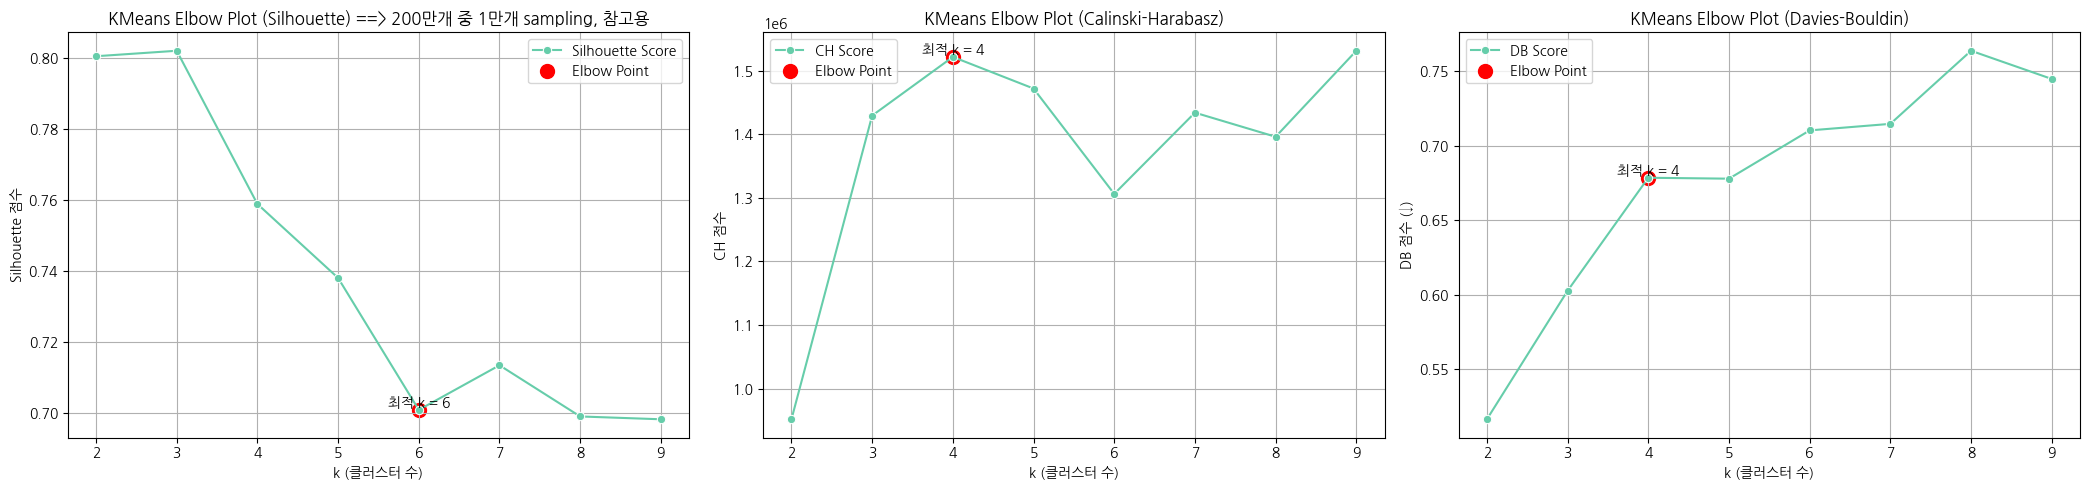

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Elbow point 계산
elbow_k_sil = find_elbow_point(result_df_kmeans, "silhouette")
elbow_score_sil = result_df_kmeans[result_df_kmeans["k"] == elbow_k_sil]["silhouette"].values[0]

elbow_k_ch = find_elbow_point(result_df_kmeans, "calinski_harabasz")
elbow_score_ch = result_df_kmeans[result_df_kmeans["k"] == elbow_k_ch]["calinski_harabasz"].values[0]

elbow_k_db = find_elbow_point(result_df_kmeans, "davies_bouldin")
elbow_score_db = result_df_kmeans[result_df_kmeans["k"] == elbow_k_db]["davies_bouldin"].values[0]

# 시각화용 데이터
df_plot = result_df_kmeans[["k", "silhouette", "calinski_harabasz", "davies_bouldin"]]

# subplot 생성 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# ① Silhouette Plot
sns.lineplot(
    data=df_plot, x="k", y="silhouette",
    marker="o", label="Silhouette Score", color="mediumaquamarine", ax=axes[0]
)
axes[0].scatter(elbow_k_sil, elbow_score_sil, s=100, color="red", label="Elbow Point")
axes[0].text(elbow_k_sil, elbow_score_sil, f"최적 k = {elbow_k_sil}", ha="center", va="bottom")
axes[0].set_title("KMeans Elbow Plot (Silhouette) ==> 200만개 중 1만개 sampling, 참고용")
axes[0].set_xlabel("k (클러스터 수)")
axes[0].set_ylabel("Silhouette 점수")
axes[0].grid(True)
axes[0].legend()

# ② Calinski-Harabasz Plot
sns.lineplot(
    data=df_plot, x="k", y="calinski_harabasz",
    marker="o", label="CH Score", color="mediumaquamarine", ax=axes[1]
)
axes[1].scatter(elbow_k_ch, elbow_score_ch, s=100, color="red", label="Elbow Point")
axes[1].text(elbow_k_ch, elbow_score_ch, f"최적 k = {elbow_k_ch}", ha="center", va="bottom")
axes[1].set_title("KMeans Elbow Plot (Calinski-Harabasz)")
axes[1].set_xlabel("k (클러스터 수)")
axes[1].set_ylabel("CH 점수")
axes[1].grid(True)
axes[1].legend()

# ③ Davies-Bouldin Plot
sns.lineplot(
    data=df_plot, x="k", y="davies_bouldin",
    marker="o", label="DB Score", color="mediumaquamarine", ax=axes[2]
)
axes[2].scatter(elbow_k_db, elbow_score_db, s=100, color="red", label="Elbow Point")
axes[2].text(elbow_k_db, elbow_score_db, f"최적 k = {elbow_k_db}", ha="center", va="bottom")
axes[2].set_title("KMeans Elbow Plot (Davies-Bouldin)")
axes[2].set_xlabel("k (클러스터 수)")
axes[2].set_ylabel("DB 점수 (↓)")
axes[2].grid(True)
axes[2].legend()

# 레이아웃 정리
plt.tight_layout()
plt.show()


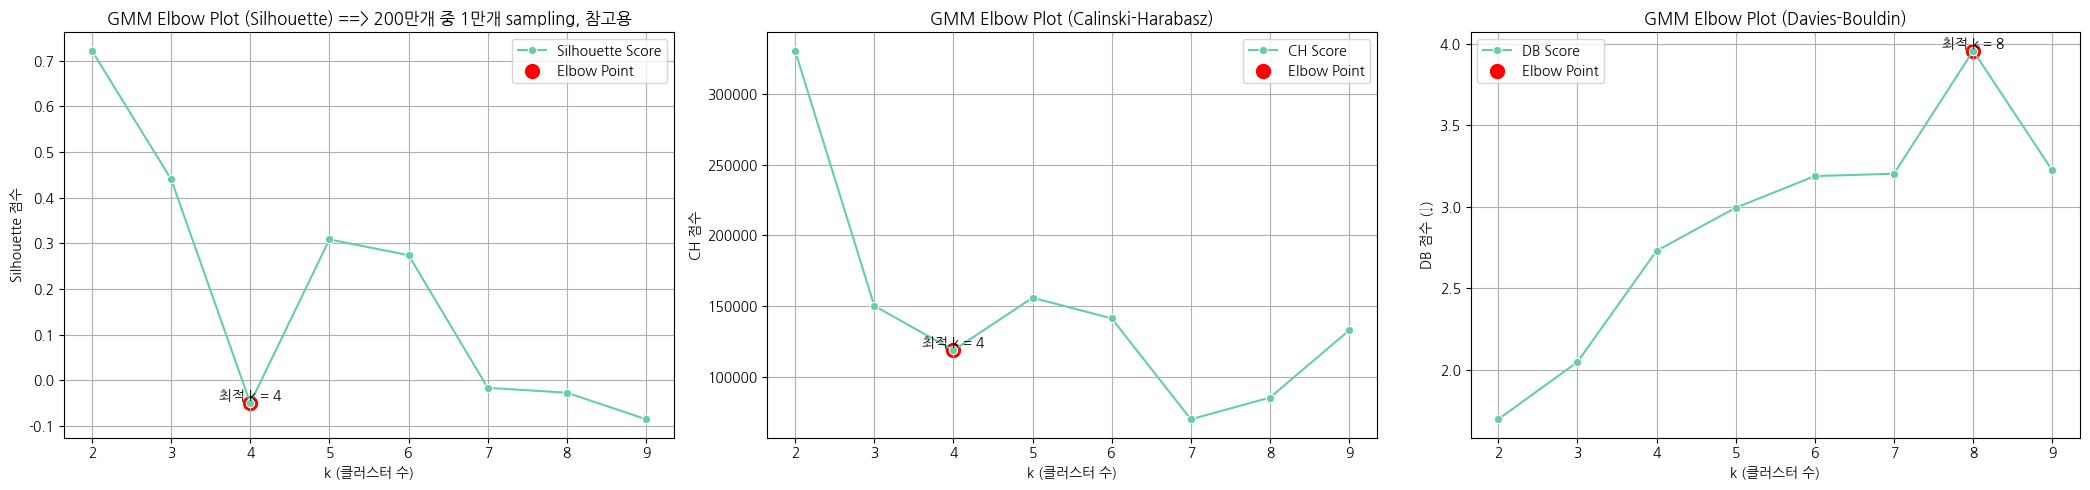

In [65]:
# Elbow point 계산 (각 지표별)
elbow_k_sil = find_elbow_point(result_df_gmm, "silhouette")
elbow_score_sil = result_df_gmm[result_df_gmm["k"] == elbow_k_sil]["silhouette"].values[0]

elbow_k_ch = find_elbow_point(result_df_gmm, "calinski_harabasz")
elbow_score_ch = result_df_gmm[result_df_gmm["k"] == elbow_k_ch]["calinski_harabasz"].values[0]

elbow_k_db = find_elbow_point(result_df_gmm, "davies_bouldin")
elbow_score_db = result_df_gmm[result_df_gmm["k"] == elbow_k_db]["davies_bouldin"].values[0]

# 시각화용 데이터
df_plot = result_df_gmm[["k", "silhouette", "calinski_harabasz", "davies_bouldin"]]

# subplot 생성 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# ① Silhouette Plot
sns.lineplot(
    data=df_plot, x="k", y="silhouette",
    marker="o", label="Silhouette Score", color="mediumaquamarine", ax=axes[0]
)
axes[0].scatter(elbow_k_sil, elbow_score_sil, s=100, color="red", label="Elbow Point")
axes[0].text(elbow_k_sil, elbow_score_sil, f"최적 k = {elbow_k_sil}", ha="center", va="bottom")
axes[0].set_title("GMM Elbow Plot (Silhouette) ==> 200만개 중 1만개 sampling, 참고용")
axes[0].set_xlabel("k (클러스터 수)")
axes[0].set_ylabel("Silhouette 점수")
axes[0].grid(True)
axes[0].legend()

# ② Calinski-Harabasz Plot
sns.lineplot(
    data=df_plot, x="k", y="calinski_harabasz",
    marker="o", label="CH Score", color="mediumaquamarine", ax=axes[1]
)
axes[1].scatter(elbow_k_ch, elbow_score_ch, s=100, color="red", label="Elbow Point")
axes[1].text(elbow_k_ch, elbow_score_ch, f"최적 k = {elbow_k_ch}", ha="center", va="bottom")
axes[1].set_title("GMM Elbow Plot (Calinski-Harabasz)")
axes[1].set_xlabel("k (클러스터 수)")
axes[1].set_ylabel("CH 점수")
axes[1].grid(True)
axes[1].legend()

# ③ Davies-Bouldin Plot
sns.lineplot(
    data=df_plot, x="k", y="davies_bouldin",
    marker="o", label="DB Score", color="mediumaquamarine", ax=axes[2]
)
axes[2].scatter(elbow_k_db, elbow_score_db, s=100, color="red", label="Elbow Point")
axes[2].text(elbow_k_db, elbow_score_db, f"최적 k = {elbow_k_db}", ha="center", va="bottom")
axes[2].set_title("GMM Elbow Plot (Davies-Bouldin)")
axes[2].set_xlabel("k (클러스터 수)")
axes[2].set_ylabel("DB 점수 (↓)")
axes[2].grid(True)
axes[2].legend()

# 전체 레이아웃 정리
plt.tight_layout()
plt.show()

In [87]:
!pip install kneed

In [97]:
from kneed import KneeLocator

# elbow point 탐지 함수
def find_elbow(df, metric: str, direction: str = "increasing"):
    x = df["k"].to_list()
    y = df[metric].to_list()

    # 자동으로 curve 설정: 증가형은 convex, 감소형은 concave
    curve_type = "convex" if direction == "increasing" else "concave"
    
    kneedle = KneeLocator(x, y, curve=curve_type, direction=direction)
    return kneedle.knee


# 각 지표별 elbow point 계산
df_k_ch = result_df_kmeans[["k", "calinski_harabasz"]]
df_k_db = result_df_kmeans[["k", "davies_bouldin"]]
df_k_sil = result_df_kmeans[["k", "silhouette"]]

elbow_k_ch = find_elbow(df_k_ch, "calinski_harabasz", direction="increasing")
elbow_k_db = find_elbow(df_k_db, "davies_bouldin", direction="decreasing")
elbow_k_sil = find_elbow(df_k_sil, "silhouette", direction="increasing")

# 각 지표별 elbow point 계산
df_g_ch = result_df_gmm[["k", "calinski_harabasz"]]
df_g_db = result_df_gmm[["k", "davies_bouldin"]]
df_g_sil = result_df_gmm[["k", "silhouette"]]

elbow_k_g_ch = find_elbow(df_g_ch, "calinski_harabasz", direction="increasing")
elbow_k_g_db = find_elbow(df_g_db, "davies_bouldin", direction="decreasing")
elbow_k_g_sil = find_elbow(df_g_sil, "silhouette", direction="increasing")

In [100]:
# KMeans 점수 추출
score_kmeans_sil = result_df_kmeans[result_df_kmeans["k"] == elbow_k_sil]["silhouette"].values[0]
score_kmeans_ch = result_df_kmeans[result_df_kmeans["k"] == elbow_k_ch]["calinski_harabasz"].values[0]
score_kmeans_db = result_df_kmeans[result_df_kmeans["k"] == elbow_k_db]["davies_bouldin"].values[0]

# GMM 점수 추출
score_gmm_sil = result_df_gmm[result_df_gmm["k"] == elbow_k_g_sil]["silhouette"].values[0]
score_gmm_ch = result_df_gmm[result_df_gmm["k"] == elbow_k_g_ch]["calinski_harabasz"].values[0]
score_gmm_db = result_df_gmm[result_df_gmm["k"] == elbow_k_g_db]["davies_bouldin"].values[0]

In [101]:
# Pandas DataFrame 생성
comparison_table = pd.DataFrame([
    {"모델": "KMeans", "지표": "Silhouette", "최적_k": elbow_k_sil, "점수": score_kmeans_sil},
    {"모델": "KMeans", "지표": "CH",         "최적_k": elbow_k_ch,  "점수": score_kmeans_ch},
    {"모델": "KMeans", "지표": "DB",         "최적_k": elbow_k_db,  "점수": score_kmeans_db},
    {"모델": "GMM",    "지표": "Silhouette", "최적_k": elbow_k_g_sil, "점수": score_gmm_sil},
    {"모델": "GMM",    "지표": "CH",         "최적_k": elbow_k_g_ch,  "점수": score_gmm_ch},
    {"모델": "GMM",    "지표": "DB",         "최적_k": elbow_k_g_db,  "점수": score_gmm_db},
])

# 정렬 우선순위 정의
sort_order = {"Silhouette": 0, "CH": 1, "DB": 2}
comparison_table["지표순위"] = comparison_table["지표"].map(sort_order)

# 정렬 (지표순위 → 모델)
comparison_table = comparison_table.sort_values(by=["지표순위", "모델"]).drop(columns="지표순위").reset_index(drop=True)

In [102]:
comparison_table

,모델,지표,최적_k,점수
0,GMM,Silhouette,9,4.970117e-01
1,KMeans,Silhouette,9,7.403464e-01
2,GMM,CH,5,1.818864e+06
3,KMeans,CH,9,1.642468e+07
4,GMM,DB,9,5.270397e-01
5,KMeans,DB,9,4.956975e-01


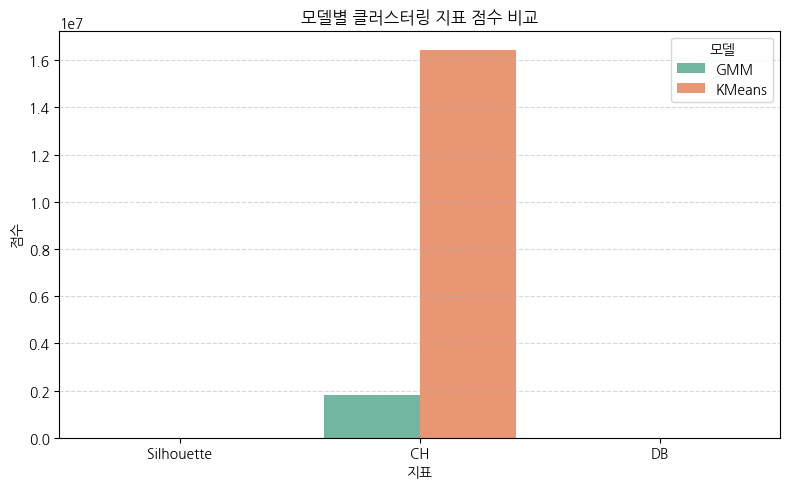

In [103]:
plt.figure(figsize=(8, 5))

# 지표별 점수를 모델별로 비교하는 막대 그래프
sns.barplot(
    data=comparison_table,
    x="지표",
    y="점수",
    hue="모델",
    palette="Set2"
)

plt.title("모델별 클러스터링 지표 점수 비교")
plt.xlabel("지표")
plt.ylabel("점수")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


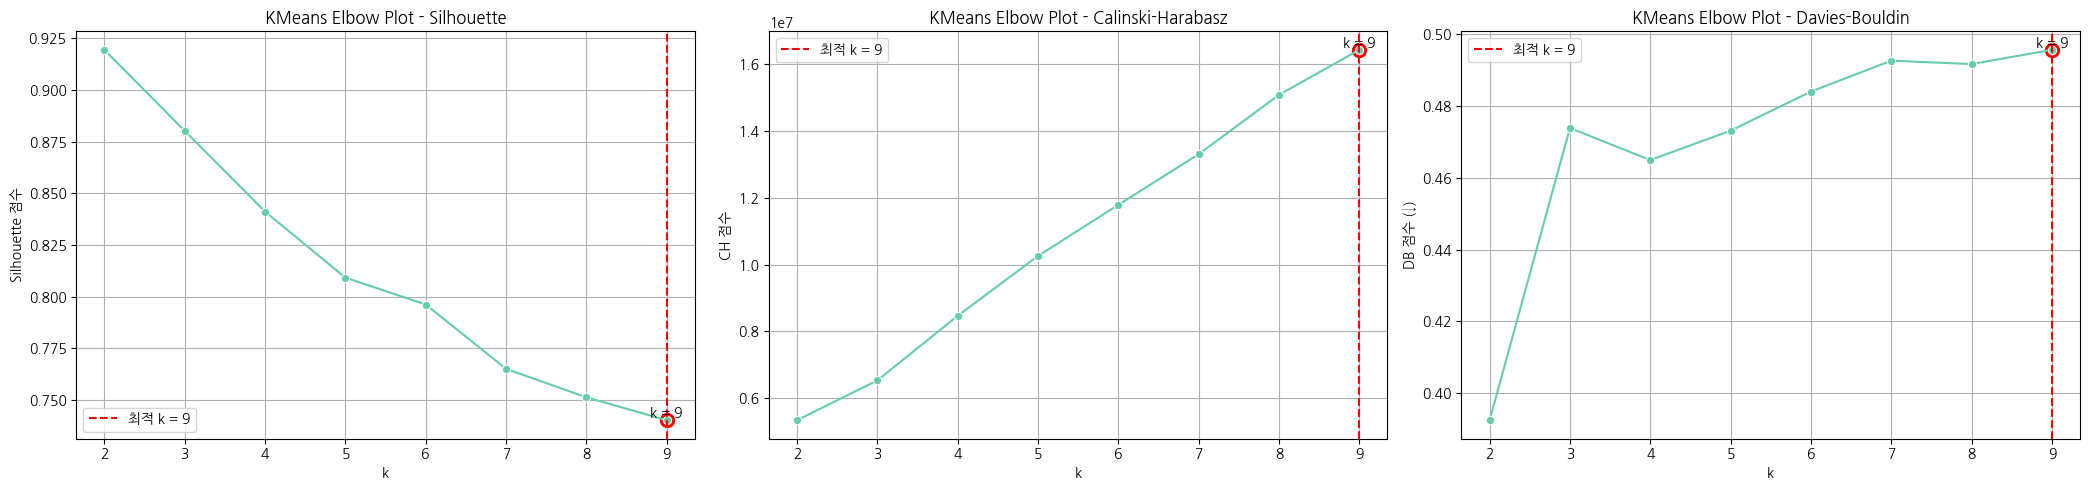

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator

# ✅ 공통 Elbow 탐지 함수
def find_elbow(df, metric: str, direction: str = "increasing"):
    x = df["k"].to_list()
    y = df[metric].to_list()
    curve_type = "convex" if direction == "increasing" else "concave"
    kneedle = KneeLocator(x, y, curve=curve_type, direction=direction)
    return kneedle.knee, x, y

# ✅ 지표별 elbow 계산
elbow_k_sil, x_sil, y_sil = find_elbow(result_df_kmeans, "silhouette", direction="increasing")
elbow_k_ch, x_ch, y_ch = find_elbow(result_df_kmeans, "calinski_harabasz", direction="increasing")
elbow_k_db, x_db, y_db = find_elbow(result_df_kmeans, "davies_bouldin", direction="decreasing")

# ✅ 점수 값도 같이 가져오기
elbow_score_sil = result_df_kmeans[result_df_kmeans["k"] == elbow_k_sil]["silhouette"].values[0]
elbow_score_ch = result_df_kmeans[result_df_kmeans["k"] == elbow_k_ch]["calinski_harabasz"].values[0]
elbow_score_db = result_df_kmeans[result_df_kmeans["k"] == elbow_k_db]["davies_bouldin"].values[0]

# ✅ subplot 생성
fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# --- ① Silhouette Plot ---
sns.lineplot(x=x_sil, y=y_sil, marker="o", ax=axes[0], color="mediumaquamarine")
axes[0].axvline(x=elbow_k_sil, linestyle="--", color="red", label=f"최적 k = {elbow_k_sil}")
axes[0].scatter(elbow_k_sil, elbow_score_sil, s=100, color="red")
axes[0].text(elbow_k_sil, elbow_score_sil, f"k = {elbow_k_sil}", ha="center", va="bottom")
axes[0].set_title("KMeans Elbow Plot - Silhouette")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Silhouette 점수")
axes[0].grid(True)
axes[0].legend()

# --- ② Calinski-Harabasz Plot ---
sns.lineplot(x=x_ch, y=y_ch, marker="o", ax=axes[1], color="mediumaquamarine")
axes[1].axvline(x=elbow_k_ch, linestyle="--", color="red", label=f"최적 k = {elbow_k_ch}")
axes[1].scatter(elbow_k_ch, elbow_score_ch, s=100, color="red")
axes[1].text(elbow_k_ch, elbow_score_ch, f"k = {elbow_k_ch}", ha="center", va="bottom")
axes[1].set_title("KMeans Elbow Plot - Calinski-Harabasz")
axes[1].set_xlabel("k")
axes[1].set_ylabel("CH 점수")
axes[1].grid(True)
axes[1].legend()

# --- ③ Davies-Bouldin Plot ---
sns.lineplot(x=x_db, y=y_db, marker="o", ax=axes[2], color="mediumaquamarine")
axes[2].axvline(x=elbow_k_db, linestyle="--", color="red", label=f"최적 k = {elbow_k_db}")
axes[2].scatter(elbow_k_db, elbow_score_db, s=100, color="red")
axes[2].text(elbow_k_db, elbow_score_db, f"k = {elbow_k_db}", ha="center", va="bottom")
axes[2].set_title("KMeans Elbow Plot - Davies-Bouldin")
axes[2].set_xlabel("k")
axes[2].set_ylabel("DB 점수 (↓)")
axes[2].grid(True)
axes[2].legend()

# ✅ 전체 레이아웃 정리
plt.tight_layout()
plt.show()


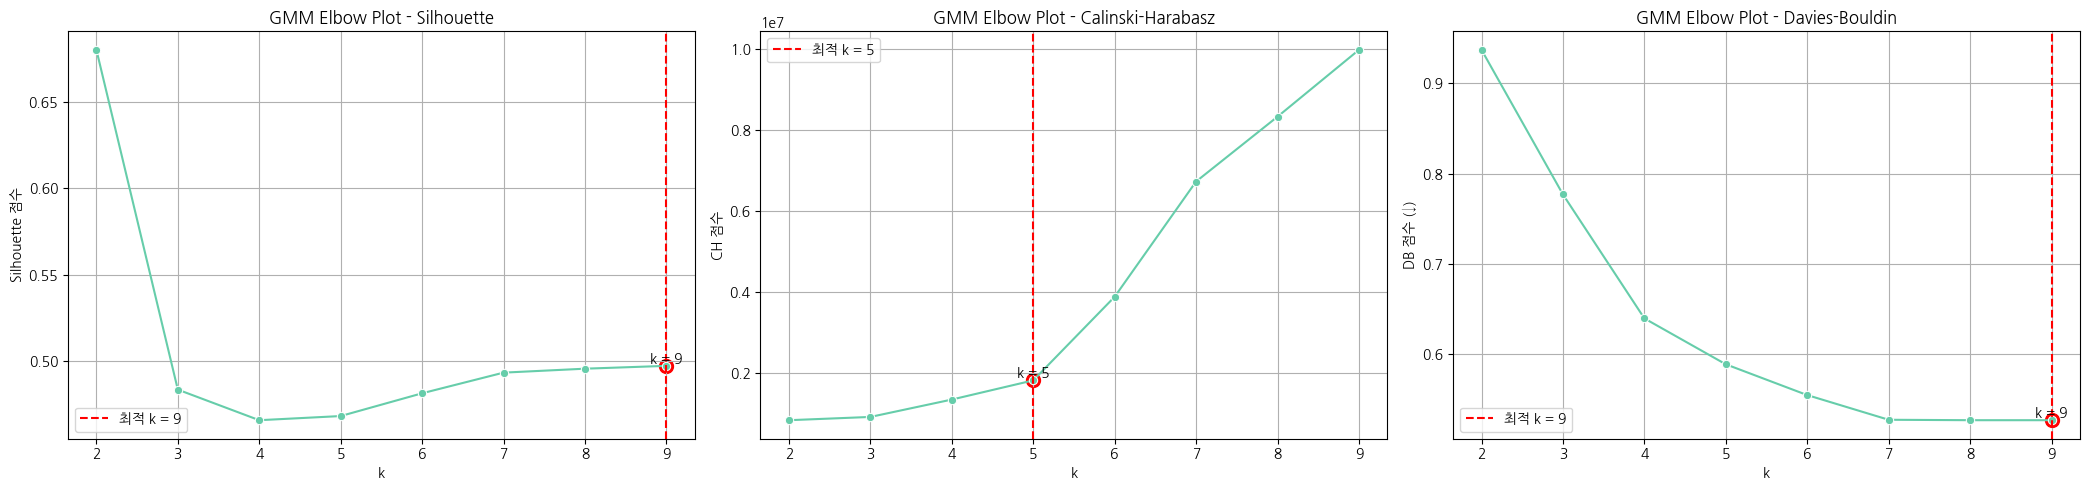

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator

# ✅ 공통 Elbow 탐지 함수
def find_elbow(df, metric: str, direction: str = "increasing"):
    x = df["k"].to_list()
    y = df[metric].to_list()
    curve_type = "convex" if direction == "increasing" else "concave"
    kneedle = KneeLocator(x, y, curve=curve_type, direction=direction)
    return kneedle.knee, x, y

# ✅ GMM 데이터에서 elbow 계산
elbow_k_sil, x_sil, y_sil = find_elbow(result_df_gmm, "silhouette", direction="increasing")
elbow_k_ch, x_ch, y_ch = find_elbow(result_df_gmm, "calinski_harabasz", direction="increasing")
elbow_k_db, x_db, y_db = find_elbow(result_df_gmm, "davies_bouldin", direction="decreasing")

# ✅ 점수 값 가져오기
elbow_score_sil = result_df_gmm[result_df_gmm["k"] == elbow_k_sil]["silhouette"].values[0]
elbow_score_ch = result_df_gmm[result_df_gmm["k"] == elbow_k_ch]["calinski_harabasz"].values[0]
elbow_score_db = result_df_gmm[result_df_gmm["k"] == elbow_k_db]["davies_bouldin"].values[0]

# ✅ subplot 생성 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# --- ① Silhouette Plot ---
sns.lineplot(x=x_sil, y=y_sil, marker="o", ax=axes[0], color="mediumaquamarine")
axes[0].axvline(x=elbow_k_sil, linestyle="--", color="red", label=f"최적 k = {elbow_k_sil}")
axes[0].scatter(elbow_k_sil, elbow_score_sil, s=100, color="red")
axes[0].text(elbow_k_sil, elbow_score_sil, f"k = {elbow_k_sil}", ha="center", va="bottom")
axes[0].set_title("GMM Elbow Plot - Silhouette")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Silhouette 점수")
axes[0].grid(True)
axes[0].legend()

# --- ② Calinski-Harabasz Plot ---
sns.lineplot(x=x_ch, y=y_ch, marker="o", ax=axes[1], color="mediumaquamarine")
axes[1].axvline(x=elbow_k_ch, linestyle="--", color="red", label=f"최적 k = {elbow_k_ch}")
axes[1].scatter(elbow_k_ch, elbow_score_ch, s=100, color="red")
axes[1].text(elbow_k_ch, elbow_score_ch, f"k = {elbow_k_ch}", ha="center", va="bottom")
axes[1].set_title("GMM Elbow Plot - Calinski-Harabasz")
axes[1].set_xlabel("k")
axes[1].set_ylabel("CH 점수")
axes[1].grid(True)
axes[1].legend()

# --- ③ Davies-Bouldin Plot ---
sns.lineplot(x=x_db, y=y_db, marker="o", ax=axes[2], color="mediumaquamarine")
axes[2].axvline(x=elbow_k_db, linestyle="--", color="red", label=f"최적 k = {elbow_k_db}")
axes[2].scatter(elbow_k_db, elbow_score_db, s=100, color="red")
axes[2].text(elbow_k_db, elbow_score_db, f"k = {elbow_k_db}", ha="center", va="bottom")
axes[2].set_title("GMM Elbow Plot - Davies-Bouldin")
axes[2].set_xlabel("k")
axes[2].set_ylabel("DB 점수 (↓)")
axes[2].grid(True)
axes[2].legend()

# ✅ 전체 레이아웃 정리
plt.tight_layout()
plt.show()


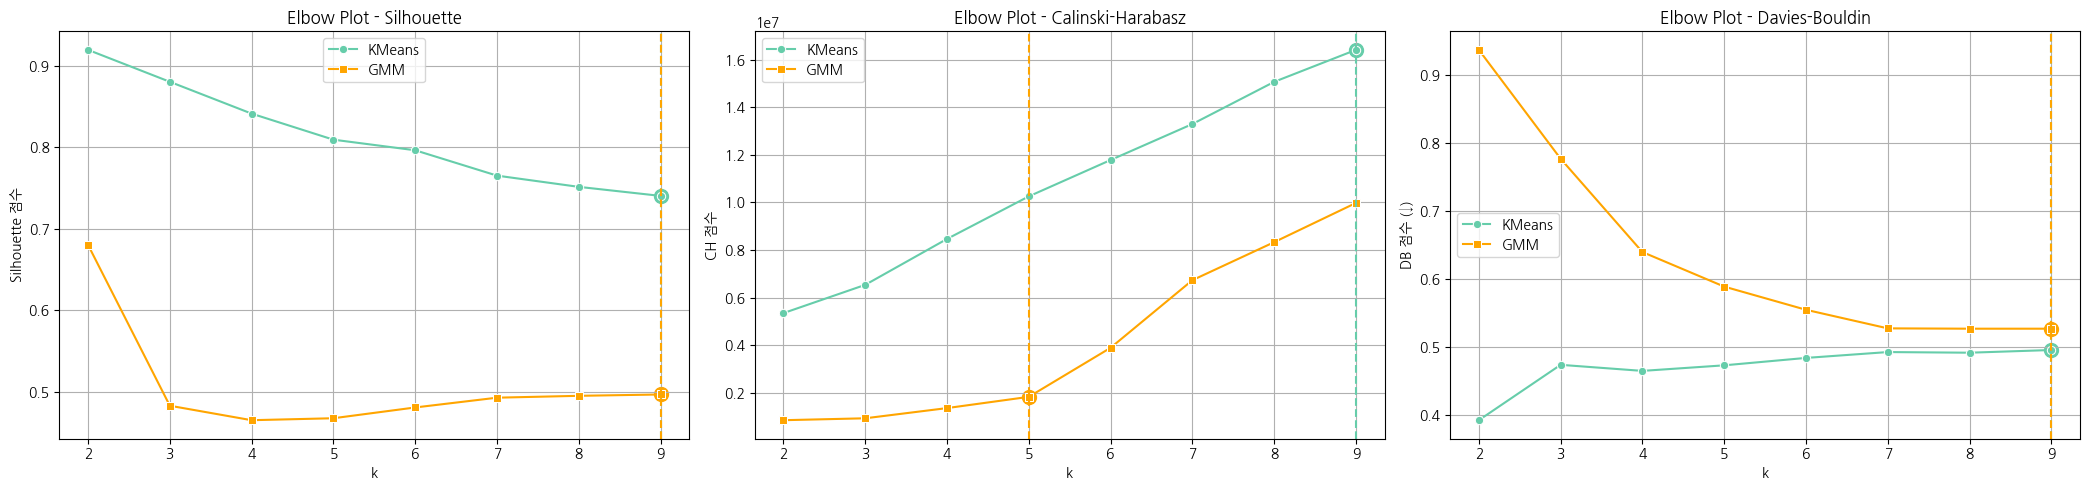

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator

# ✅ Elbow 탐지 함수
def find_elbow(df, metric, direction):
    x = df["k"].to_list()
    y = df[metric].to_list()
    curve_type = "convex" if direction == "increasing" else "concave"
    knee = KneeLocator(x, y, curve=curve_type, direction=direction)
    return knee.knee, x, y

# ✅ elbow 계산 (각 지표, 모델별)
elbow_k_kmeans_sil, x_k_sil, y_k_sil = find_elbow(result_df_kmeans, "silhouette", "increasing")
elbow_k_kmeans_ch, x_k_ch, y_k_ch = find_elbow(result_df_kmeans, "calinski_harabasz", "increasing")
elbow_k_kmeans_db, x_k_db, y_k_db = find_elbow(result_df_kmeans, "davies_bouldin", "decreasing")

elbow_k_gmm_sil, x_g_sil, y_g_sil = find_elbow(result_df_gmm, "silhouette", "increasing")
elbow_k_gmm_ch, x_g_ch, y_g_ch = find_elbow(result_df_gmm, "calinski_harabasz", "increasing")
elbow_k_gmm_db, x_g_db, y_g_db = find_elbow(result_df_gmm, "davies_bouldin", "decreasing")

# ✅ 점수값 추출
def get_score(df, k, col): return df[df["k"] == k][col].values[0]

score_kmeans_sil = get_score(result_df_kmeans, elbow_k_kmeans_sil, "silhouette")
score_kmeans_ch = get_score(result_df_kmeans, elbow_k_kmeans_ch, "calinski_harabasz")
score_kmeans_db = get_score(result_df_kmeans, elbow_k_kmeans_db, "davies_bouldin")

score_gmm_sil = get_score(result_df_gmm, elbow_k_gmm_sil, "silhouette")
score_gmm_ch = get_score(result_df_gmm, elbow_k_gmm_ch, "calinski_harabasz")
score_gmm_db = get_score(result_df_gmm, elbow_k_gmm_db, "davies_bouldin")

# ✅ subplot 생성 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# --- ① Silhouette ---
sns.lineplot(x=x_k_sil, y=y_k_sil, label="KMeans", color="mediumaquamarine", ax=axes[0], marker="o")
sns.lineplot(x=x_g_sil, y=y_g_sil, label="GMM", color="orange", ax=axes[0], marker="s")
axes[0].axvline(x=elbow_k_kmeans_sil, linestyle="--", color="mediumaquamarine")
axes[0].axvline(x=elbow_k_gmm_sil, linestyle="--", color="orange")
axes[0].scatter(elbow_k_kmeans_sil, score_kmeans_sil, color="mediumaquamarine", s=100)
axes[0].scatter(elbow_k_gmm_sil, score_gmm_sil, color="orange", s=100)
axes[0].set_title("Elbow Plot - Silhouette")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Silhouette 점수")
axes[0].grid(True)
axes[0].legend()

# --- ② Calinski-Harabasz ---
sns.lineplot(x=x_k_ch, y=y_k_ch, label="KMeans", color="mediumaquamarine", ax=axes[1], marker="o")
sns.lineplot(x=x_g_ch, y=y_g_ch, label="GMM", color="orange", ax=axes[1], marker="s")
axes[1].axvline(x=elbow_k_kmeans_ch, linestyle="--", color="mediumaquamarine")
axes[1].axvline(x=elbow_k_gmm_ch, linestyle="--", color="orange")
axes[1].scatter(elbow_k_kmeans_ch, score_kmeans_ch, color="mediumaquamarine", s=100)
axes[1].scatter(elbow_k_gmm_ch, score_gmm_ch, color="orange", s=100)
axes[1].set_title("Elbow Plot - Calinski-Harabasz")
axes[1].set_xlabel("k")
axes[1].set_ylabel("CH 점수")
axes[1].grid(True)
axes[1].legend()

# --- ③ Davies-Bouldin ---
sns.lineplot(x=x_k_db, y=y_k_db, label="KMeans", color="mediumaquamarine", ax=axes[2], marker="o")
sns.lineplot(x=x_g_db, y=y_g_db, label="GMM", color="orange", ax=axes[2], marker="s")
axes[2].axvline(x=elbow_k_kmeans_db, linestyle="--", color="mediumaquamarine")
axes[2].axvline(x=elbow_k_gmm_db, linestyle="--", color="orange")
axes[2].scatter(elbow_k_kmeans_db, score_kmeans_db, color="mediumaquamarine", s=100)
axes[2].scatter(elbow_k_gmm_db, score_gmm_db, color="orange", s=100)
axes[2].set_title("Elbow Plot - Davies-Bouldin")
axes[2].set_xlabel("k")
axes[2].set_ylabel("DB 점수 (↓)")
axes[2].grid(True)
axes[2].legend()

# ✅ 전체 정리
plt.tight_layout()
plt.show()


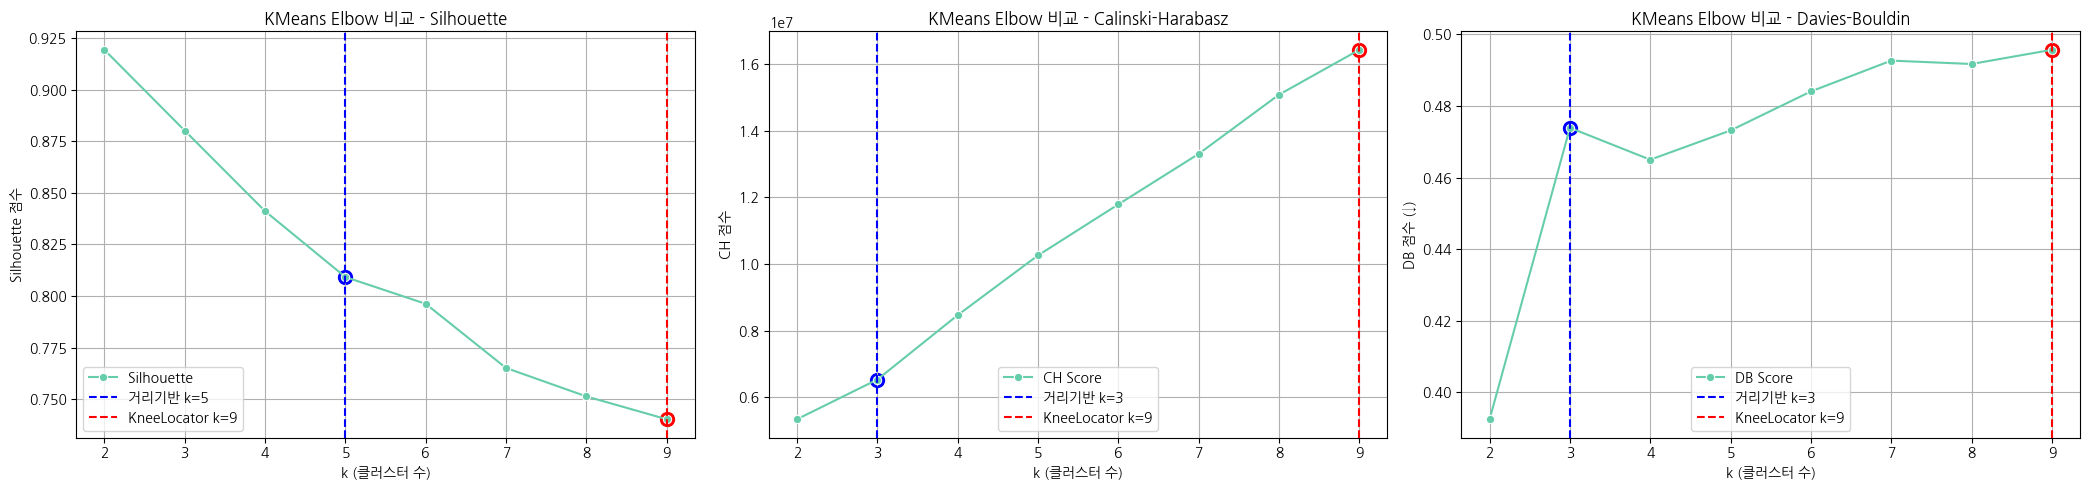

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from kneed import KneeLocator

# ✅ 거리기반 elbow 계산 함수
def find_elbow_point(df, score_col):
    x = df["k"].to_numpy()
    y = df[score_col].to_numpy()
    start = np.array([x[0], y[0]])
    end = np.array([x[-1], y[-1]])
    distances = []
    for i in range(len(x)):
        point = np.array([x[i], y[i]])
        vec_line = end - start
        vec_point = point - start
        proj_len = np.dot(vec_line, vec_point) / np.linalg.norm(vec_line)
        proj_point = start + proj_len * vec_line / np.linalg.norm(vec_line)
        dist = np.linalg.norm(point - proj_point)
        distances.append(dist)
    best_idx = int(np.argmax(distances))
    return int(x[best_idx])

# ✅ KneeLocator 방식
def find_elbow_kneedf(df, metric, direction="increasing"):
    x = df["k"].to_list()
    y = df[metric].to_list()
    curve_type = "convex" if direction == "increasing" else "concave"
    kneedle = KneeLocator(x, y, curve=curve_type, direction=direction)
    return kneedle.knee

# ✅ 개별 지표 처리 ------------------------------

# Silhouette
df_sil = result_df_kmeans[["k", "silhouette"]].copy()
elbow_k_distance_sil = find_elbow_point(df_sil, "silhouette")
elbow_k_knee_sil = find_elbow_kneedf(df_sil, "silhouette", direction="increasing")
score_dist_sil = df_sil[df_sil["k"] == elbow_k_distance_sil]["silhouette"].values[0]
score_knee_sil = df_sil[df_sil["k"] == elbow_k_knee_sil]["silhouette"].values[0]

# CH
df_ch = result_df_kmeans[["k", "calinski_harabasz"]].copy()
elbow_k_distance_ch = find_elbow_point(df_ch, "calinski_harabasz")
elbow_k_knee_ch = find_elbow_kneedf(df_ch, "calinski_harabasz", direction="increasing")
score_dist_ch = df_ch[df_ch["k"] == elbow_k_distance_ch]["calinski_harabasz"].values[0]
score_knee_ch = df_ch[df_ch["k"] == elbow_k_knee_ch]["calinski_harabasz"].values[0]

# DB
df_db = result_df_kmeans[["k", "davies_bouldin"]].copy()
elbow_k_distance_db = find_elbow_point(df_db, "davies_bouldin")
elbow_k_knee_db = find_elbow_kneedf(df_db, "davies_bouldin", direction="decreasing")
score_dist_db = df_db[df_db["k"] == elbow_k_distance_db]["davies_bouldin"].values[0]
score_knee_db = df_db[df_db["k"] == elbow_k_knee_db]["davies_bouldin"].values[0]

# ✅ 시각화 ------------------------------

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# --- Silhouette
sns.lineplot(data=df_sil, x="k", y="silhouette", ax=axes[0], color="mediumaquamarine", marker="o", label="Silhouette")
axes[0].axvline(x=elbow_k_distance_sil, linestyle="--", color="blue", label=f"거리기반 k={elbow_k_distance_sil}")
axes[0].scatter(elbow_k_distance_sil, score_dist_sil, color="blue", s=100)
axes[0].axvline(x=elbow_k_knee_sil, linestyle="--", color="red", label=f"KneeLocator k={elbow_k_knee_sil}")
axes[0].scatter(elbow_k_knee_sil, score_knee_sil, color="red", s=100)
axes[0].set_title("KMeans Elbow 비교 - Silhouette")
axes[0].set_xlabel("k (클러스터 수)")
axes[0].set_ylabel("Silhouette 점수")
axes[0].legend()
axes[0].grid(True)

# --- CH
sns.lineplot(data=df_ch, x="k", y="calinski_harabasz", ax=axes[1], color="mediumaquamarine", marker="o", label="CH Score")
axes[1].axvline(x=elbow_k_distance_ch, linestyle="--", color="blue", label=f"거리기반 k={elbow_k_distance_ch}")
axes[1].scatter(elbow_k_distance_ch, score_dist_ch, color="blue", s=100)
axes[1].axvline(x=elbow_k_knee_ch, linestyle="--", color="red", label=f"KneeLocator k={elbow_k_knee_ch}")
axes[1].scatter(elbow_k_knee_ch, score_knee_ch, color="red", s=100)
axes[1].set_title("KMeans Elbow 비교 - Calinski-Harabasz")
axes[1].set_xlabel("k (클러스터 수)")
axes[1].set_ylabel("CH 점수")
axes[1].legend()
axes[1].grid(True)

# --- DB
sns.lineplot(data=df_db, x="k", y="davies_bouldin", ax=axes[2], color="mediumaquamarine", marker="o", label="DB Score")
axes[2].axvline(x=elbow_k_distance_db, linestyle="--", color="blue", label=f"거리기반 k={elbow_k_distance_db}")
axes[2].scatter(elbow_k_distance_db, score_dist_db, color="blue", s=100)
axes[2].axvline(x=elbow_k_knee_db, linestyle="--", color="red", label=f"KneeLocator k={elbow_k_knee_db}")
axes[2].scatter(elbow_k_knee_db, score_knee_db, color="red", s=100)
axes[2].set_title("KMeans Elbow 비교 - Davies-Bouldin")
axes[2].set_xlabel("k (클러스터 수)")
axes[2].set_ylabel("DB 점수 (↓)")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


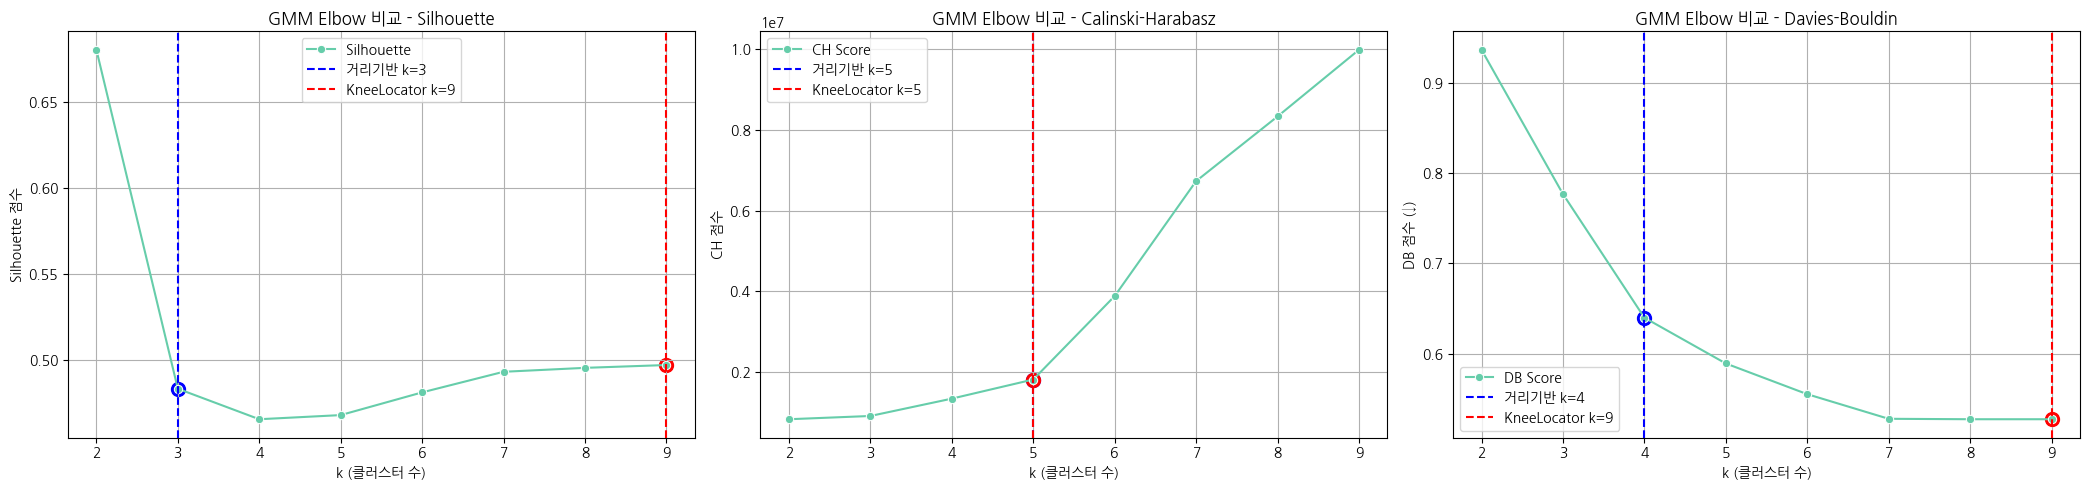

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from kneed import KneeLocator

# ✅ 거리기반 elbow 계산 함수
def find_elbow_point(df, score_col):
    x = df["k"].to_numpy()
    y = df[score_col].to_numpy()
    start = np.array([x[0], y[0]])
    end = np.array([x[-1], y[-1]])
    distances = []
    for i in range(len(x)):
        point = np.array([x[i], y[i]])
        vec_line = end - start
        vec_point = point - start
        proj_len = np.dot(vec_line, vec_point) / np.linalg.norm(vec_line)
        proj_point = start + proj_len * vec_line / np.linalg.norm(vec_line)
        dist = np.linalg.norm(point - proj_point)
        distances.append(dist)
    best_idx = int(np.argmax(distances))
    return int(x[best_idx])

# ✅ KneeLocator 방식 elbow 계산 함수
def find_elbow_kneedf(df, metric, direction="increasing"):
    x = df["k"].to_list()
    y = df[metric].to_list()
    curve_type = "convex" if direction == "increasing" else "concave"
    kneedle = KneeLocator(x, y, curve=curve_type, direction=direction)
    return kneedle.knee

# ✅ GMM 지표별 elbow 계산 ----------------------

# Silhouette
df_gmm_sil = result_df_gmm[["k", "silhouette"]].copy()
elbow_k_distance_gmm_sil = find_elbow_point(df_gmm_sil, "silhouette")
elbow_k_knee_gmm_sil = find_elbow_kneedf(df_gmm_sil, "silhouette", direction="increasing")
score_dist_gmm_sil = df_gmm_sil[df_gmm_sil["k"] == elbow_k_distance_gmm_sil]["silhouette"].values[0]
score_knee_gmm_sil = df_gmm_sil[df_gmm_sil["k"] == elbow_k_knee_gmm_sil]["silhouette"].values[0]

# CH
df_gmm_ch = result_df_gmm[["k", "calinski_harabasz"]].copy()
elbow_k_distance_gmm_ch = find_elbow_point(df_gmm_ch, "calinski_harabasz")
elbow_k_knee_gmm_ch = find_elbow_kneedf(df_gmm_ch, "calinski_harabasz", direction="increasing")
score_dist_gmm_ch = df_gmm_ch[df_gmm_ch["k"] == elbow_k_distance_gmm_ch]["calinski_harabasz"].values[0]
score_knee_gmm_ch = df_gmm_ch[df_gmm_ch["k"] == elbow_k_knee_gmm_ch]["calinski_harabasz"].values[0]

# DB
df_gmm_db = result_df_gmm[["k", "davies_bouldin"]].copy()
elbow_k_distance_gmm_db = find_elbow_point(df_gmm_db, "davies_bouldin")
elbow_k_knee_gmm_db = find_elbow_kneedf(df_gmm_db, "davies_bouldin", direction="decreasing")
score_dist_gmm_db = df_gmm_db[df_gmm_db["k"] == elbow_k_distance_gmm_db]["davies_bouldin"].values[0]
score_knee_gmm_db = df_gmm_db[df_gmm_db["k"] == elbow_k_knee_gmm_db]["davies_bouldin"].values[0]

# ✅ 시각화 ----------------------

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# --- Silhouette
sns.lineplot(data=df_gmm_sil, x="k", y="silhouette", ax=axes[0], color="mediumaquamarine", marker="o", label="Silhouette")
axes[0].axvline(x=elbow_k_distance_gmm_sil, linestyle="--", color="blue", label=f"거리기반 k={elbow_k_distance_gmm_sil}")
axes[0].scatter(elbow_k_distance_gmm_sil, score_dist_gmm_sil, color="blue", s=100)
axes[0].axvline(x=elbow_k_knee_gmm_sil, linestyle="--", color="red", label=f"KneeLocator k={elbow_k_knee_gmm_sil}")
axes[0].scatter(elbow_k_knee_gmm_sil, score_knee_gmm_sil, color="red", s=100)
axes[0].set_title("GMM Elbow 비교 - Silhouette")
axes[0].set_xlabel("k (클러스터 수)")
axes[0].set_ylabel("Silhouette 점수")
axes[0].legend()
axes[0].grid(True)

# --- CH
sns.lineplot(data=df_gmm_ch, x="k", y="calinski_harabasz", ax=axes[1], color="mediumaquamarine", marker="o", label="CH Score")
axes[1].axvline(x=elbow_k_distance_gmm_ch, linestyle="--", color="blue", label=f"거리기반 k={elbow_k_distance_gmm_ch}")
axes[1].scatter(elbow_k_distance_gmm_ch, score_dist_gmm_ch, color="blue", s=100)
axes[1].axvline(x=elbow_k_knee_gmm_ch, linestyle="--", color="red", label=f"KneeLocator k={elbow_k_knee_gmm_ch}")
axes[1].scatter(elbow_k_knee_gmm_ch, score_knee_gmm_ch, color="red", s=100)
axes[1].set_title("GMM Elbow 비교 - Calinski-Harabasz")
axes[1].set_xlabel("k (클러스터 수)")
axes[1].set_ylabel("CH 점수")
axes[1].legend()
axes[1].grid(True)

# --- DB
sns.lineplot(data=df_gmm_db, x="k", y="davies_bouldin", ax=axes[2], color="mediumaquamarine", marker="o", label="DB Score")
axes[2].axvline(x=elbow_k_distance_gmm_db, linestyle="--", color="blue", label=f"거리기반 k={elbow_k_distance_gmm_db}")
axes[2].scatter(elbow_k_distance_gmm_db, score_dist_gmm_db, color="blue", s=100)
axes[2].axvline(x=elbow_k_knee_gmm_db, linestyle="--", color="red", label=f"KneeLocator k={elbow_k_knee_gmm_db}")
axes[2].scatter(elbow_k_knee_gmm_db, score_knee_gmm_db, color="red", s=100)
axes[2].set_title("GMM Elbow 비교 - Davies-Bouldin")
axes[2].set_xlabel("k (클러스터 수)")
axes[2].set_ylabel("DB 점수 (↓)")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [112]:
import pandas as pd

# 결과표 생성
elbow_df = pd.DataFrame(elbow_results)

# 보기 좋게 정렬
elbow_df = elbow_df[[
    "지표", "거리기반_k", "거리기반_점수", "KneeLocator_k", "KneeLocator_점수"
]]

In [113]:
elbow_df

,지표,거리기반_k,거리기반_점수,KneeLocator_k,KneeLocator_점수
0,Silhouette,3,4.832286e-01,9,4.970117e-01
1,Calinski-Harabasz,5,1.818864e+06,5,1.818864e+06
2,Davies-Bouldin,4,6.397533e-01,9,5.270397e-01


# 라벨 붙이기

In [116]:
customer_agg

고객ID,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출,평균_총점수,거래기간(개월),연령대,최대_보유상품종류,평균_보유상품종류
i64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i8
2772302056,169565.217391,0.0,0.0,0.0,1.9504e7,7725.911594,23,30,2,2
7084529048,1.8806e6,0.0,1.3503e7,7096.774194,0.0,1028.068817,36,40,3,2
7592653016,267741.935484,0.0,0.0,0.0,0.0,45.72043,36,60,1,1
7225330529,2.0387e6,0.0,0.0,0.0,790322.580645,505.637634,36,60,2,1
2383687052,0.0,0.0,0.0,0.0,4.28e6,1057.466667,10,60,1,1
…,…,…,…,…,…,…,…,…,…,…
9318661998,22580.645161,0.0,0.0,0.0,0.0,16.731183,36,50,1,0
5735375166,0.0,2.3613e6,0.0,0.0,0.0,112.83871,36,40,2,1
6754471871,6.8419e6,3.0355e7,0.0,0.0,0.0,1844.193548,36,50,2,2


In [117]:
clustering_origin

고객ID,연령대,평균_총점수,분위수_충성도등급
i64,i64,f64,str
2772302056,30,7725.911594,"""상"""
7084529048,40,1028.068817,"""상"""
7592653016,60,45.72043,"""하"""
7225330529,60,505.637634,"""상"""
2383687052,60,1057.466667,"""상"""
…,…,…,…
9318661998,50,16.731183,"""하"""
5735375166,40,112.83871,"""중"""
6754471871,50,1844.193548,"""상"""


In [128]:
# from sklearn.cluster import KMeans
# from sklearn.mixture import GaussianMixture
# import pandas as pd

# # 원본 복사
# df = clustering_origin.copy()

# # 클러스터링 대상 컬럼 (1개 또는 여러 개 가능)
# X = df[["평균_총점수"]].values

# # ✅ 최적 k값 정의 (미리 계산되어 있어야 함)
# k_values = {
#     "KMeans_실루엣_거리기반": elbow_k_distance_sil,
#     "KMeans_실루엣_KneeLocator": elbow_k_knee_sil,
#     "KMeans_CH_거리기반": elbow_k_distance_ch,
#     "KMeans_CH_KneeLocator": elbow_k_knee_ch,
#     "KMeans_DB_거리기반": elbow_k_distance_db,
#     "KMeans_DB_KneeLocator": elbow_k_knee_db,
#     "GMM_실루엣_거리기반": elbow_k_distance_gmm_sil,
#     "GMM_실루엣_KneeLocator": elbow_k_knee_gmm_sil,
#     "GMM_CH_거리기반": elbow_k_distance_gmm_ch,
#     "GMM_CH_KneeLocator": elbow_k_knee_gmm_ch,
#     "GMM_DB_거리기반": elbow_k_distance_gmm_db,
#     "GMM_DB_KneeLocator": elbow_k_knee_gmm_db,
# }

# # ✅ 클러스터링 및 라벨링
# for label_name, k in k_values.items():
#     if label_name.startswith("KMeans"):
#         model = KMeans(n_clusters=k, random_state=42)
#         labels = model.fit_predict(X)
#     elif label_name.startswith("GMM"):
#         model = GaussianMixture(n_components=k, random_state=42)
#         labels = model.fit_predict(X)
#     else:
#         raise ValueError(f"Unknown model type in label: {label_name}")
    
#     df[label_name] = labels

# # ✅ 결과 확인
# print(df.head())

In [130]:
# from sklearn.cluster import KMeans
# from sklearn.mixture import GaussianMixture

# def add_clustering_label(df, label_name: str, k: int, X):
#     if label_name.startswith("KMeans"):
#         model = KMeans(n_clusters=k, random_state=42)
#         labels = model.fit_predict(X)
#     elif label_name.startswith("GMM"):
#         model = GaussianMixture(n_components=k, random_state=42)
#         labels = model.fit_predict(X)
#     else:
#         raise ValueError(f"Unknown model type in label: {label_name}")
    
#     df[label_name] = labels
#     print(f"✅ 라벨 추가 완료: {label_name} (k={k})")
#     return df

In [131]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import time

def add_clustering_label(df, label_name: str, k: int, X):
    """KMeans 또는 GMM 클러스터링 라벨을 df에 추가하고 소요시간을 출력"""
    print(f"▶ 실행 중: {label_name} (k={k})")
    start = time.time()

    # 모델 선택 및 학습
    if label_name.startswith("KMeans"):
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X)
    elif label_name.startswith("GMM"):
        model = GaussianMixture(n_components=k, random_state=42)
        labels = model.fit_predict(X)
    else:
        raise ValueError(f"Unknown model type in label: {label_name}")

    # 라벨 저장
    df[label_name] = labels

    end = time.time()
    print(f"✅ 완료: {label_name} | 소요시간: {end - start:.2f}초\n")
    return df


In [132]:
k_values = {
    "KMeans_실루엣_거리기반": elbow_k_distance_sil,
    "KMeans_실루엣_KneeLocator": elbow_k_knee_sil,
    "KMeans_CH_거리기반": elbow_k_distance_ch,
    "KMeans_CH_KneeLocator": elbow_k_knee_ch,
    "KMeans_DB_거리기반": elbow_k_distance_db,
    "KMeans_DB_KneeLocator": elbow_k_knee_db,
    "GMM_실루엣_거리기반": elbow_k_distance_gmm_sil,
    "GMM_실루엣_KneeLocator": elbow_k_knee_gmm_sil,
    "GMM_CH_거리기반": elbow_k_distance_gmm_ch,
    "GMM_CH_KneeLocator": elbow_k_knee_gmm_ch,
    "GMM_DB_거리기반": elbow_k_distance_gmm_db,
    "GMM_DB_KneeLocator": elbow_k_knee_gmm_db,
}


In [133]:
# # 클러스터링 대상
# df = clustering_origin.copy()
# X = df[["평균_총점수"]].values

# # 예시: 한 개 실행
# df = add_clustering_label(df, "KMeans_실루엣_거리기반", elbow_k_distance_sil, X)

In [134]:
for label, k in k_values.items():
    df = clustering_origin.copy()
    df = add_clustering_label(df, label, k, X)
    # 필요시 중간 저장 가능: df.to_parquet("temp_labeled.parquet")

▶ 실행 중: KMeans_실루엣_거리기반 (k=5)
✅ 완료: KMeans_실루엣_거리기반 | 소요시간: 1.02초

▶ 실행 중: KMeans_실루엣_KneeLocator (k=9)
✅ 완료: KMeans_실루엣_KneeLocator | 소요시간: 3.74초

▶ 실행 중: KMeans_CH_거리기반 (k=3)
✅ 완료: KMeans_CH_거리기반 | 소요시간: 0.81초

▶ 실행 중: KMeans_CH_KneeLocator (k=9)
✅ 완료: KMeans_CH_KneeLocator | 소요시간: 2.74초

▶ 실행 중: KMeans_DB_거리기반 (k=3)
✅ 완료: KMeans_DB_거리기반 | 소요시간: 0.92초

▶ 실행 중: KMeans_DB_KneeLocator (k=9)
✅ 완료: KMeans_DB_KneeLocator | 소요시간: 2.82초

▶ 실행 중: GMM_실루엣_거리기반 (k=3)
✅ 완료: GMM_실루엣_거리기반 | 소요시간: 29.14초

▶ 실행 중: GMM_실루엣_KneeLocator (k=9)
✅ 완료: GMM_실루엣_KneeLocator | 소요시간: 127.99초

▶ 실행 중: GMM_CH_거리기반 (k=5)
✅ 완료: GMM_CH_거리기반 | 소요시간: 72.72초

▶ 실행 중: GMM_CH_KneeLocator (k=5)
✅ 완료: GMM_CH_KneeLocator | 소요시간: 72.49초

▶ 실행 중: GMM_DB_거리기반 (k=4)
✅ 완료: GMM_DB_거리기반 | 소요시간: 45.02초

▶ 실행 중: GMM_DB_KneeLocator (k=9)
✅ 완료: GMM_DB_KneeLocator | 소요시간: 127.60초



In [135]:
df.head()

,고객ID,연령대,평균_총점수,분위수_충성도등급,KMeans_실루엣_거리기반,KMeans_실루엣_KneeLocator,KMeans_CH_거리기반,KMeans_CH_KneeLocator,KMeans_DB_거리기반,KMeans_DB_KneeLocator,GMM_실루엣_거리기반,GMM_실루엣_KneeLocator,GMM_CH_거리기반,GMM_CH_KneeLocator,GMM_DB_거리기반,GMM_DB_KneeLocator
0,2772302056,30,7725.911594,상,3,6,1,6,1,6,2,4,2,2,2,4
1,7084529048,40,1028.068817,상,0,5,0,5,0,5,1,2,3,3,1,2
2,7592653016,60,45.720430,하,0,0,0,0,0,0,0,0,0,0,0,0
3,7225330529,60,505.637634,상,0,0,0,0,0,0,1,2,4,4,3,2
4,2383687052,60,1057.466667,상,0,5,0,5,0,5,1,2,3,3,1,2


In [136]:
df.shape

(1978693, 16)

In [137]:
temp.shape

(56322649, 14)

In [138]:
customer_agg.shape

(1978693, 11)

In [141]:
df.to_csv('./dataset/클러스터링결과숫자.csv', encoding='utf-8')

In [143]:
# 클러스터링 한국말로 바꾸기 는 클러스터가 너무 많아서 고민후 하겠음